In [1]:
import pandas as pd
import numpy as np
import glob
import re
import seaborn as sns 
import matplotlib.pyplot as plt

## General visualizations of Eye tracker data health

In [4]:
data_frame = pd.read_csv("/Volumes/TwoTeras/1_Experiment_2/Eye_Tracking/Pre_processed/Data_Sets/Complete_Data_AngularV.cvs")

In [5]:
data_frame.head()

Unnamed: 0  index  SubjectID  Session  SessionSubsection  \
0           0      0       1031        1                  1   
1           1      1       1031        1                  1   
2           2      2       1031        1                  1   
3           3      3       1031        1                  1   
4           4      4       1031        1                  1   

   timeStampDataPointEnd  combinedGazeValidityBitmask  \
0           1.668436e+09                            3   
1           1.668436e+09                            3   
2           1.668436e+09                            3   
3           1.668436e+09                            3   
4           1.668436e+09                            3   

   eyePositionCombinedWorld.x  eyePositionCombinedWorld.y  \
0                  -59.062084                    2.408754   
1                  -59.062084                    2.408754   
2                  -59.062084                    2.408754   
3                  -59.003208                    2.408757   
4                  -59.003208                    2.408757   

   eyePositionCombinedWorld.z  ...  combined_vel     thresh  isFix  \
0                   34.788044  ...           NaN  42.933244    NaN   
1                   34.788044  ...      0.000000  42.933244    0.0   
2                   34.788044  ...      0.000000  42.933244    0.0   
3                   34.788631  ...    144.818129  42.933244    NaN   
4                   34.788631  ...      0.000000  42.933244    0.0   

   corrected_vel  events    length  distance  avg_dist           names  \
0            NaN     NaN       NaN       NaN       NaN  pavement_O.002   
1            NaN     2.0  0.011408  6.394362  6.394362  pavement_O.002   
2            NaN    -2.0  0.011408  6.394362  6.394362  pavement_O.002   
3     144.818129    -1.0  0.021328       NaN       NaN  pavement_O.002   
4       0.000000     2.0  0.183023  6.577809  6.585500  pavement_O.002   

  Collider_CategoricalN  
0            Background  
1            Background  
2            Background  
3            Background  
4            Background  

[5 rows x 46 columns]

In [4]:
# Just if I wanted to keep only complete cases 
#Mask_IDs = data_frame['SubjectID'].isin([479, 2361, 3246, 3572, 3976, 5238, 5531, 7264, 8695])
#data_frame_final = data_frame.loc[~Mask_IDs]

In [6]:
data_frame.combinedGazeValidityBitmask.value_counts(normalize=True)

3    0.942763
0    0.057237
Name: combinedGazeValidityBitmask, dtype: float64

In [8]:
Blinks = pd.DataFrame(data_frame.groupby(["SubjectID", "Session"])["combinedGazeValidityBitmask"].value_counts(normalize=True))
Blinks.rename(columns ={"combinedGazeValidityBitmask": "Percentage"}, inplace=True)
Blinks.reset_index(inplace=True)
Blinks.loc[:, 'Validity'] = Blinks['combinedGazeValidityBitmask'].replace( {3:"Valid", 0:"Invalid"})

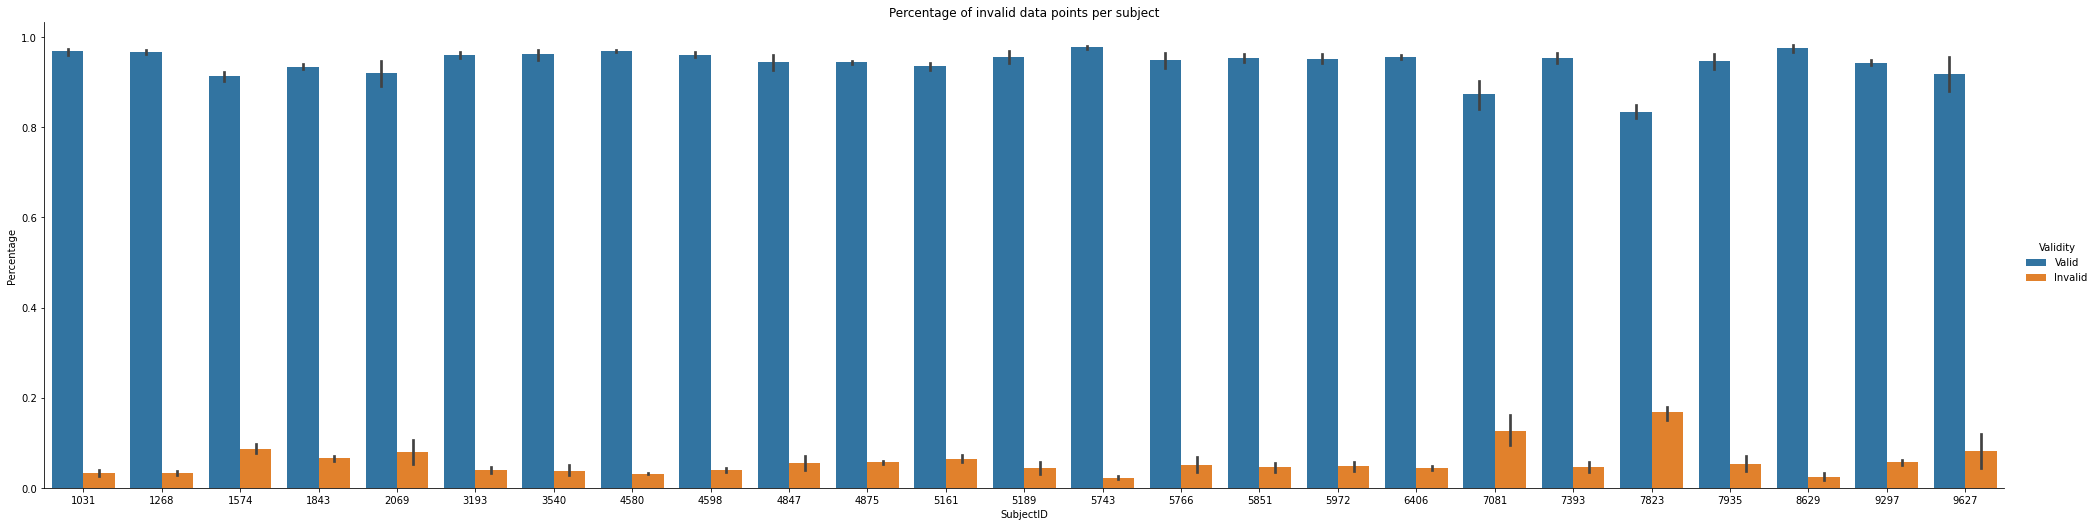

In [9]:
sns.catplot(data=Blinks, hue="Validity", y="Percentage", x="SubjectID", kind="bar", \
            height=7, aspect=4).set(title="Percentage of invalid data points per subject")

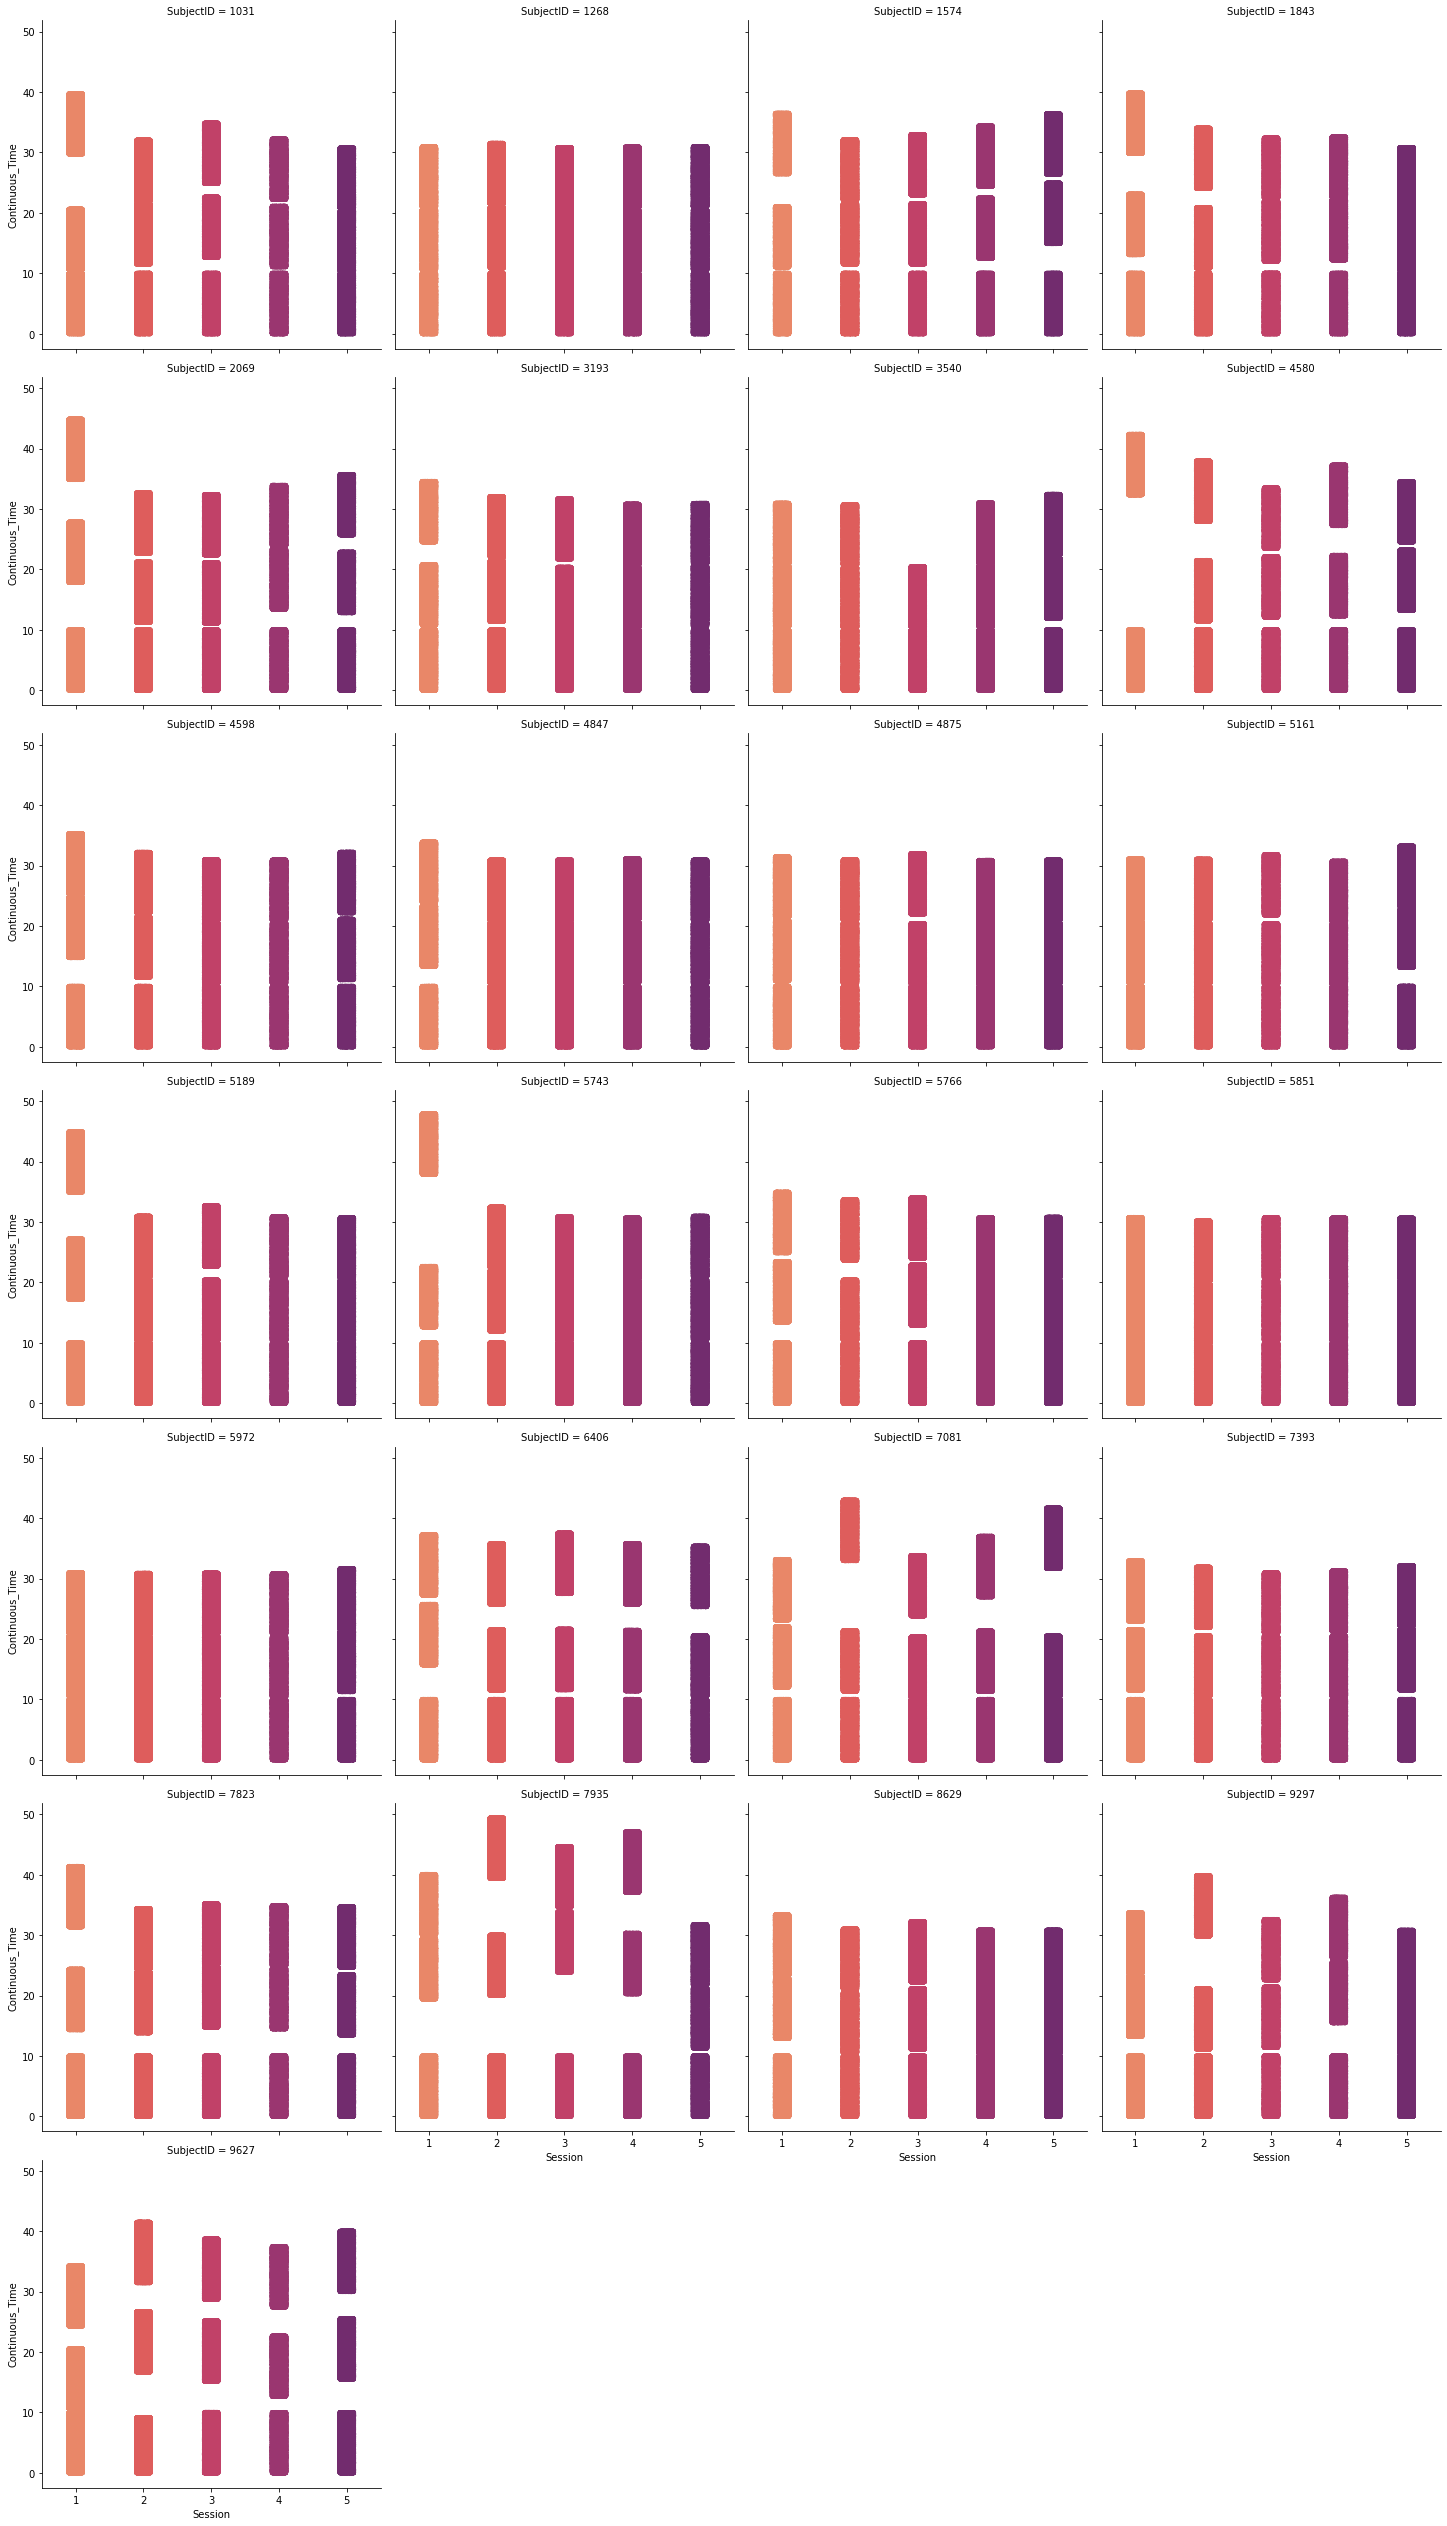

In [10]:
plot = data_frame[data_frame.Continuous_Time < 120]
sns.catplot(data=plot, col="SubjectID", y="Continuous_Time", x="Session",  col_wrap=4, palette="flare")

## Gaze processing

In [12]:
# Take  final row per fixation (the duration, average distance is the same all through the rows of the same fixation)
gaze = data_frame[data_frame.events == -2].copy()

### Get all gazes whose duration is more than 3.5 median standard deviations out 

In [13]:
gaze["Median_Standard_Duration"] = np.nanmedian(abs(gaze.length - np.nanmedian(gaze.length))) * 1.4826
gaze.loc[:, "gaze_mad_z"] = abs(gaze.length.tolist() - np.nanmedian(gaze.length)) / gaze.Median_Standard_Duration.tolist()
gaze.loc[:,"Outlier_Gaze_Length"] = np.where(gaze["gaze_mad_z"] > 3.5, "Out", "Stays")
gaze_no_out = gaze[gaze.Outlier_Gaze_Length != "Out"].copy()
gaze_no_out.to_csv("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/Complete_Data_AngularV_NO_Outliers.cvs")

In [14]:
gaze.Outlier_Gaze_Length.value_counts(normalize=True)

Stays    0.955387
Out      0.044613
Name: Outlier_Gaze_Length, dtype: float64

In [16]:
# See how many data points we're loosing by excluding outliers 
display(gaze.shape)
display(gaze_no_out.shape)

(714384, 49)

(682513, 49)

### Gaze Visualizations on complete data 

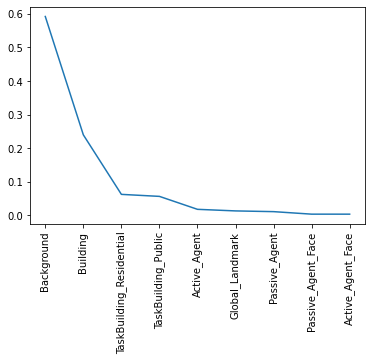

In [28]:
ax = gaze_no_out.Collider_CategoricalN.value_counts(normalize=True).plot()
ax.tick_params(axis='x', labelrotation = 90)

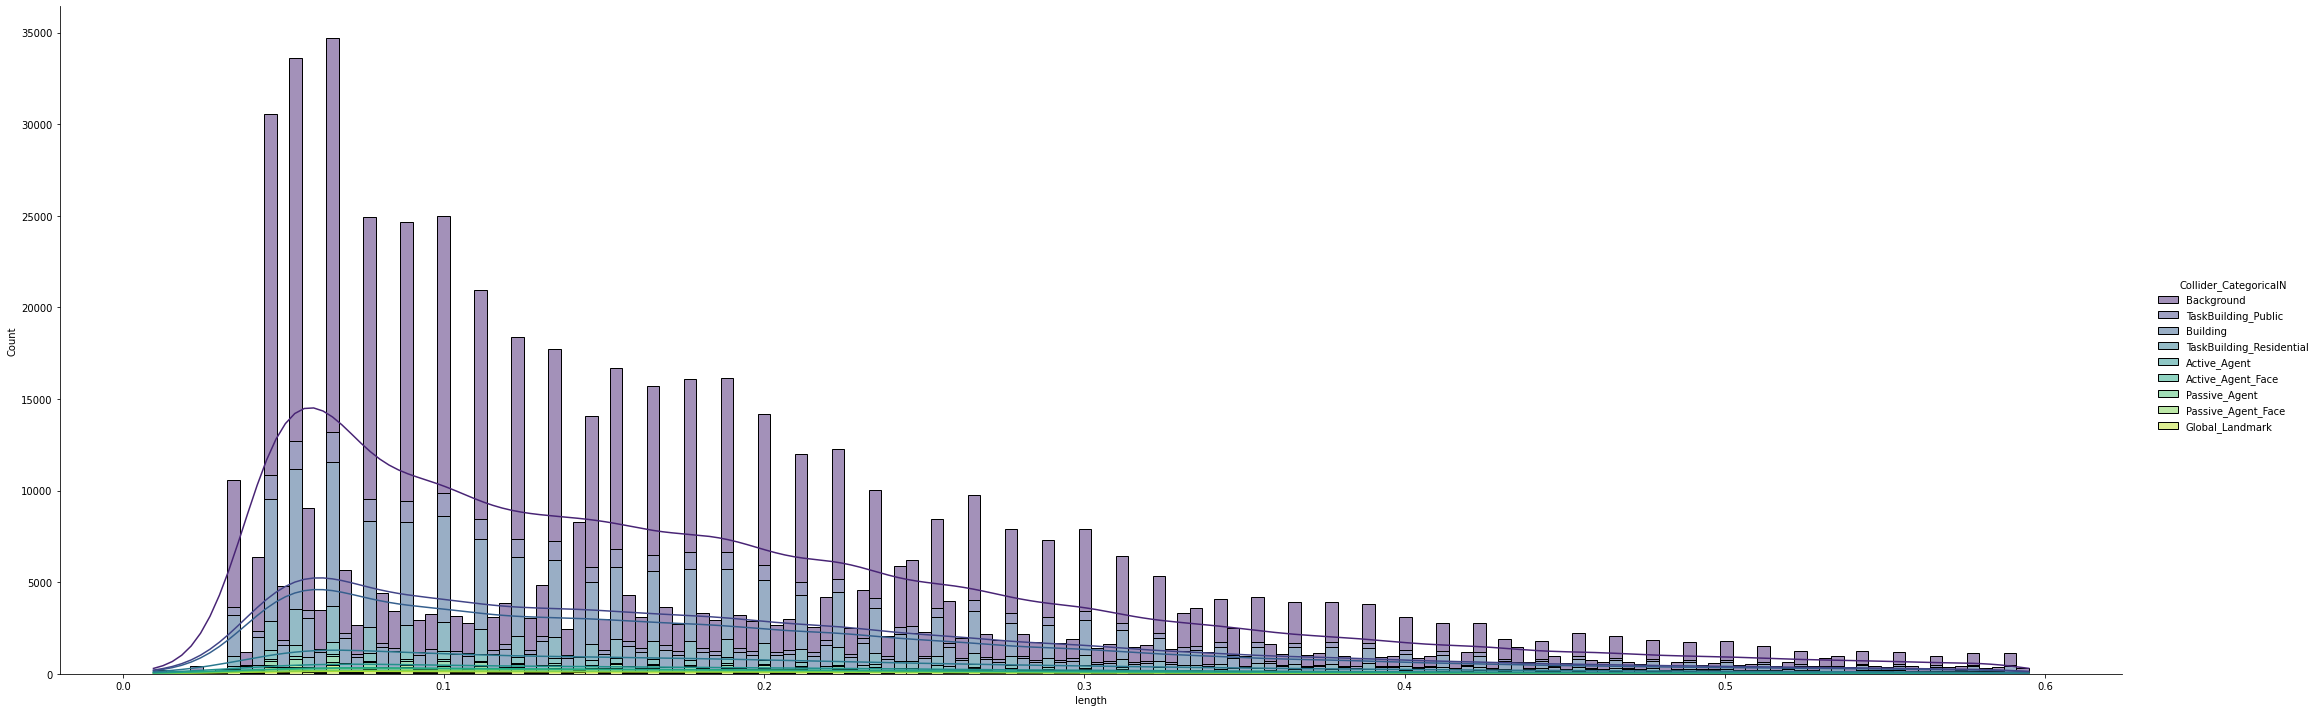

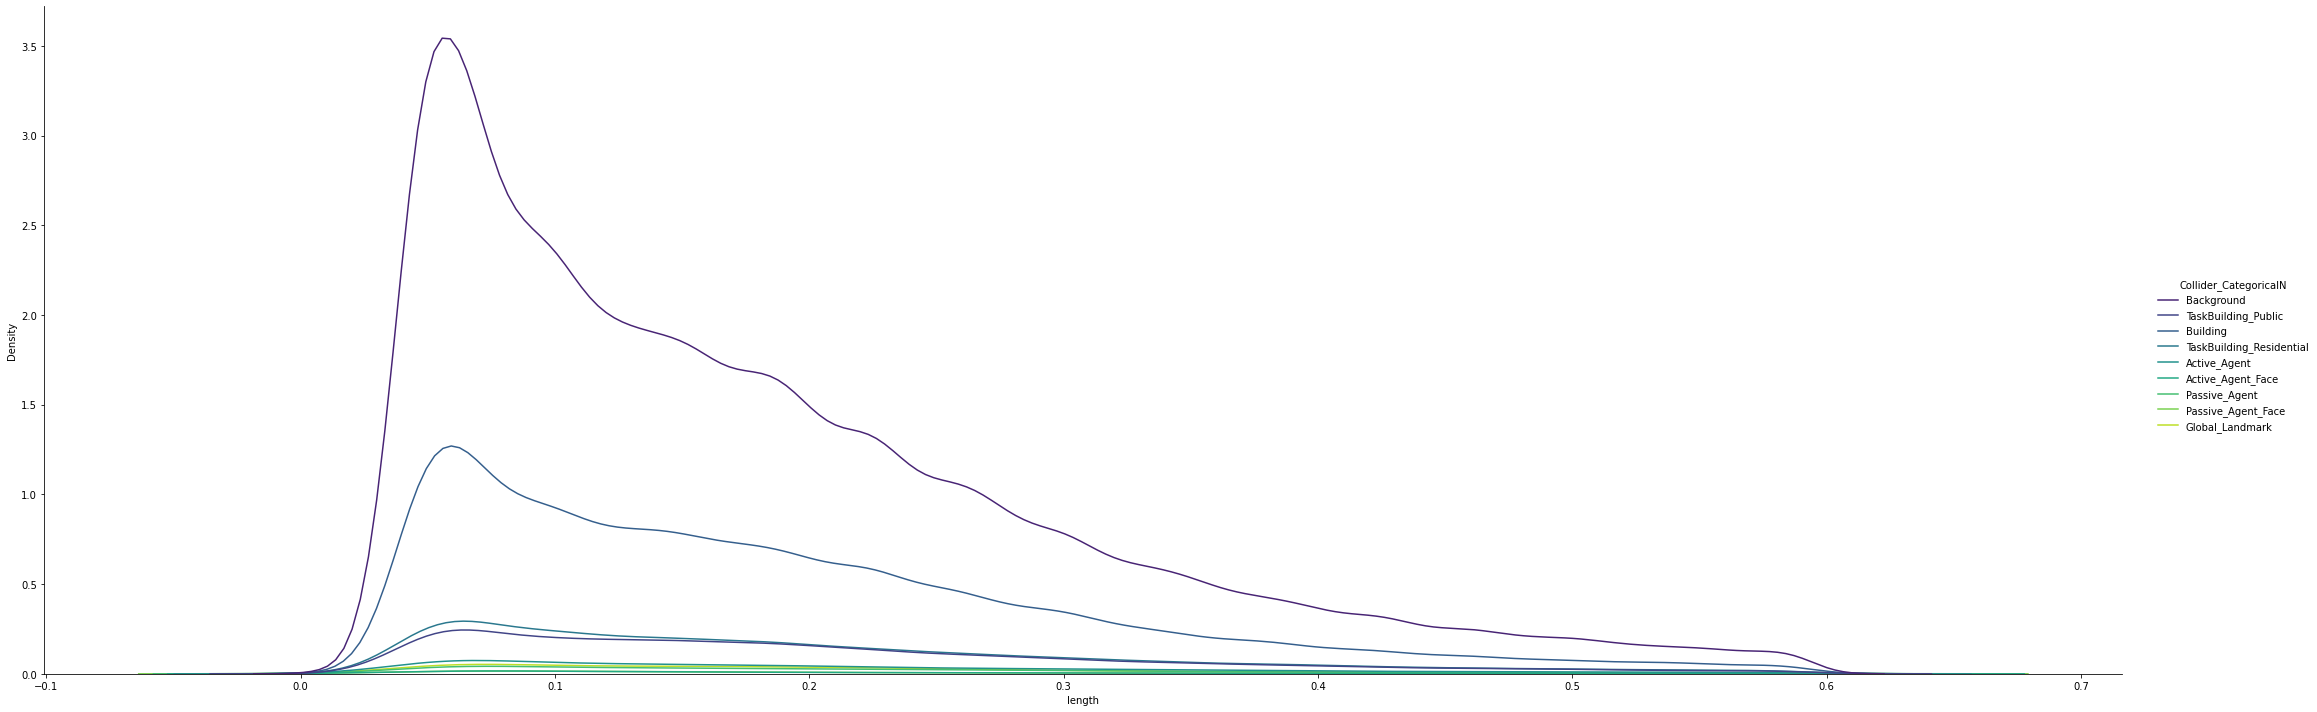

In [32]:
sns.displot(x='length', hue="Collider_CategoricalN",
             data=gaze_no_out, 
            height=10, aspect= 3, kde=True, palette="viridis",  multiple="stack")

sns.displot(x='length', hue="Collider_CategoricalN",
             data=gaze_no_out, 
            height=10, aspect= 3, kind="kde", palette="viridis")

In [131]:
# Since the collider names are too detailed, here we create a dictionary with patterns to classify them into our categories of interest
patterns = {'\d{2}_Sa':'Passive_Agent', '\d{2}_Cma':'Active_Agent', 'Building_\d+': 'Building'}
patterns.update(dict.fromkeys(['Castle-TaskBuilding_56', 'Crane_59','HighSilo-TaskBuilding_49', 'Windmill-TaskBuilding_10_1', 'Church-TaskBuilding_16'], 'Global_Landmark'))
patterns.update(dict.fromkeys(['^TaskBuilding_2$','^TaskBuilding_3$', '^TaskBuilding_5$', '^TaskBuilding_8$', '^TaskBuilding_9$', '^TaskBuilding_11$', '^TaskBuilding_13$', '^TaskBuilding_14$', '^TaskBuilding_20$', 
                               '^TaskBuilding_21$', '^TaskBuilding_23$','^TaskBuilding_27$', '^TaskBuilding_29$', '^TaskBuilding_32$', '^TaskBuilding_34$',  '^TaskBuilding_38$', '^TaskBuilding_41$', '^TaskBuilding_42$', 
                               '^TaskBuilding_44$', '^TaskBuilding_45$', '^TaskBuilding_47$', '^TaskBuilding_50$', '^TaskBuilding_51$', '^TaskBuilding_52$', 'BasketballCourt_58', 'Construction_57', 
                               '^Graffity_02$', '^Graffity_03$', '^Graffity_05$', '^Graffity_08$', '^Graffity_09$', '^Graffity_11$', '^Graffity_13$', '^Graffity_14$', '^Graffity_20$', 
                               '^Graffity_21$', '^Graffity_23$', '^Graffity_27$', '^Graffity_29$', '^Graffity_32$', '^Graffity_34$', '^Graffity_38$', '^Graffity_41$', '^Graffity_42$', 
                               '^Graffity_44$', '^Graffity_45$', '^Graffity_47$',  '^Graffity_50$', '^Graffity_51$', '^Graffity_52$'], 'TaskBuilding_Public'))

patterns.update(dict.fromkeys(['^TaskBuilding_1$','^TaskBuilding_4$', '^TaskBuilding_6$', '^TaskBuilding_7$', '^TaskBuilding_12$', '^TaskBuilding_15$', '^TaskBuilding_17$', '^TaskBuilding_18$', '^TaskBuilding_19$', 
                               '^TaskBuilding_22$', '^TaskBuilding_24$','^TaskBuilding_25$', '^TaskBuilding_26$', '^TaskBuilding_28$', '^TaskBuilding_30$',  '^TaskBuilding_31$', '^TaskBuilding_33$', '^TaskBuilding_35$', 
                               '^TaskBuilding_36$', '^TaskBuilding_37$', '^TaskBuilding_39$', '^TaskBuilding_40$', '^TaskBuilding_43$', '^TaskBuilding_48$', '^TaskBuilding_54$','^TaskBuilding_55$',
                               '^Graffity_01$','^Graffity_04$', '^Graffity_06$', '^Graffity_07$', '^Graffity_12$', '^Graffity_15$', '^Graffity_17$', '^Graffity_18$', '^Graffity_19$', '^Graffity_22$', 
                               '^Graffity_24$','^Graffity_25$', '^Graffity_26$', '^Graffity_28$', '^Graffity_30$',  '^Graffity_31$', '^Graffity_33$', '^Graffity_35$', '^Graffity_36$', '^Graffity_37$', '^Graffity_39$', 
                               '^Graffity_40$', '^Graffity_43$', '^Graffity_48$', '^Graffity_54$', '^Graffity_55$' ], 'TaskBuilding_Residential'))
default_val = 'Background'

In [132]:
gaze_no_out["Collider_CategoricalN"] =  gaze_no_out['names'].apply(lambda x: next((val for key, val in patterns.items() if re.match(key, x)), default_val))
#string_to_add = "_Face"
# Define the condition and the string to add
#Mask_1f = ((data_frame_gaze_no_out_ONLY_TEST['Collider_CategoricalN'] == "Active_Agent") & (data_frame_gaze_no_out_ONLY_TEST['Face_Hits'] == "Face")) | ((data_frame_gaze_no_out_ONLY_TEST['Collider_CategoricalN'] == "Passive_Agent") & (data_frame_gaze_no_out_ONLY_TEST['Face_Hits'] == "Face"))
#data_frame_gaze_no_out_ONLY_TEST.loc[Mask_1f, 'Collider_CategoricalN'] = data_frame_gaze_no_out_ONLY_TEST.loc[Mask_1f, 'Collider_CategoricalN'] + string_to_add

In [133]:
# Keep only the gazes that happened on the categories of interest
data_frame_gaze_no_out_ONLY_TEST = gaze_no_out[(gaze_no_out.Collider_CategoricalN != "Background") & (gaze_no_out.Collider_CategoricalN != "Building")].copy()

In [134]:
data_frame_gaze_no_out_ONLY_TEST.Collider_CategoricalN.value_counts(normalize=True)

TaskBuilding_Residential    0.371022
TaskBuilding_Public         0.335450
Active_Agent                0.127760
Passive_Agent               0.087107
Global_Landmark             0.078660
Name: Collider_CategoricalN, dtype: float64

In [124]:
data_frame_gaze_no_out_ONLY_TEST.head()

index  SubjectID  Session  SessionSubsection  timeStampDataPointEnd  \
70      70       1031        1                  1           1.668436e+09   
217    217       1031        1                  1           1.668436e+09   
228    228       1031        1                  1           1.668436e+09   
246    246       1031        1                  1           1.668436e+09   
267    267       1031        1                  1           1.668436e+09   

     combinedGazeValidityBitmask  eyePositionCombinedWorld.x  \
70                             3                  -59.048164   
217                            3                  -59.069908   
228                            3                  -59.072449   
246                            3                  -59.089291   
267                            3                  -59.123661   

     eyePositionCombinedWorld.y  eyePositionCombinedWorld.z  \
70                     2.419450                   34.760757   
217                    2.435466                   34.760433   
228                    2.433517                   34.757622   
246                    2.427562                   34.763134   
267                    2.431819                   34.757259   

     eyeDirectionCombinedWorld.y  ...    distance    avg_dist  \
70                      0.017248  ...  130.993693  130.973733   
217                     0.034346  ...    9.926199    9.926104   
228                     0.084445  ...   12.326112   12.320977   
246                     0.018391  ...    7.234847    7.232347   
267                     0.340278  ...   12.349276   12.375113   

               names     Collider_CategoricalN  Median_Standard_Duration  \
70   TaskBuilding_27       TaskBuilding_Public                  0.125027   
217  TaskBuilding_35  TaskBuilding_Residential                  0.125027   
228  TaskBuilding_35  TaskBuilding_Residential                  0.125027   
246           23_Cma              Active_Agent                  0.125027   
267      Graffity_35  TaskBuilding_Residential                  0.125027   

     gaze_mad_z  Outlier_Gaze_Length Hit_Object_Category          recoded  \
70     0.111002                Stays            Building  TaskBuilding_27   
217    0.551508                Stays            Building  TaskBuilding_35   
228    0.634820                Stays            Building  TaskBuilding_35   
246    1.221807                Stays               Agent           23_Cma   
267    1.233697                Stays            Graffity  TaskBuilding_35   

     cumsum_length  
70        0.171120  
217       0.088288  
228       0.166160  
246       0.310001  
267       0.477648  

[5 rows x 51 columns]

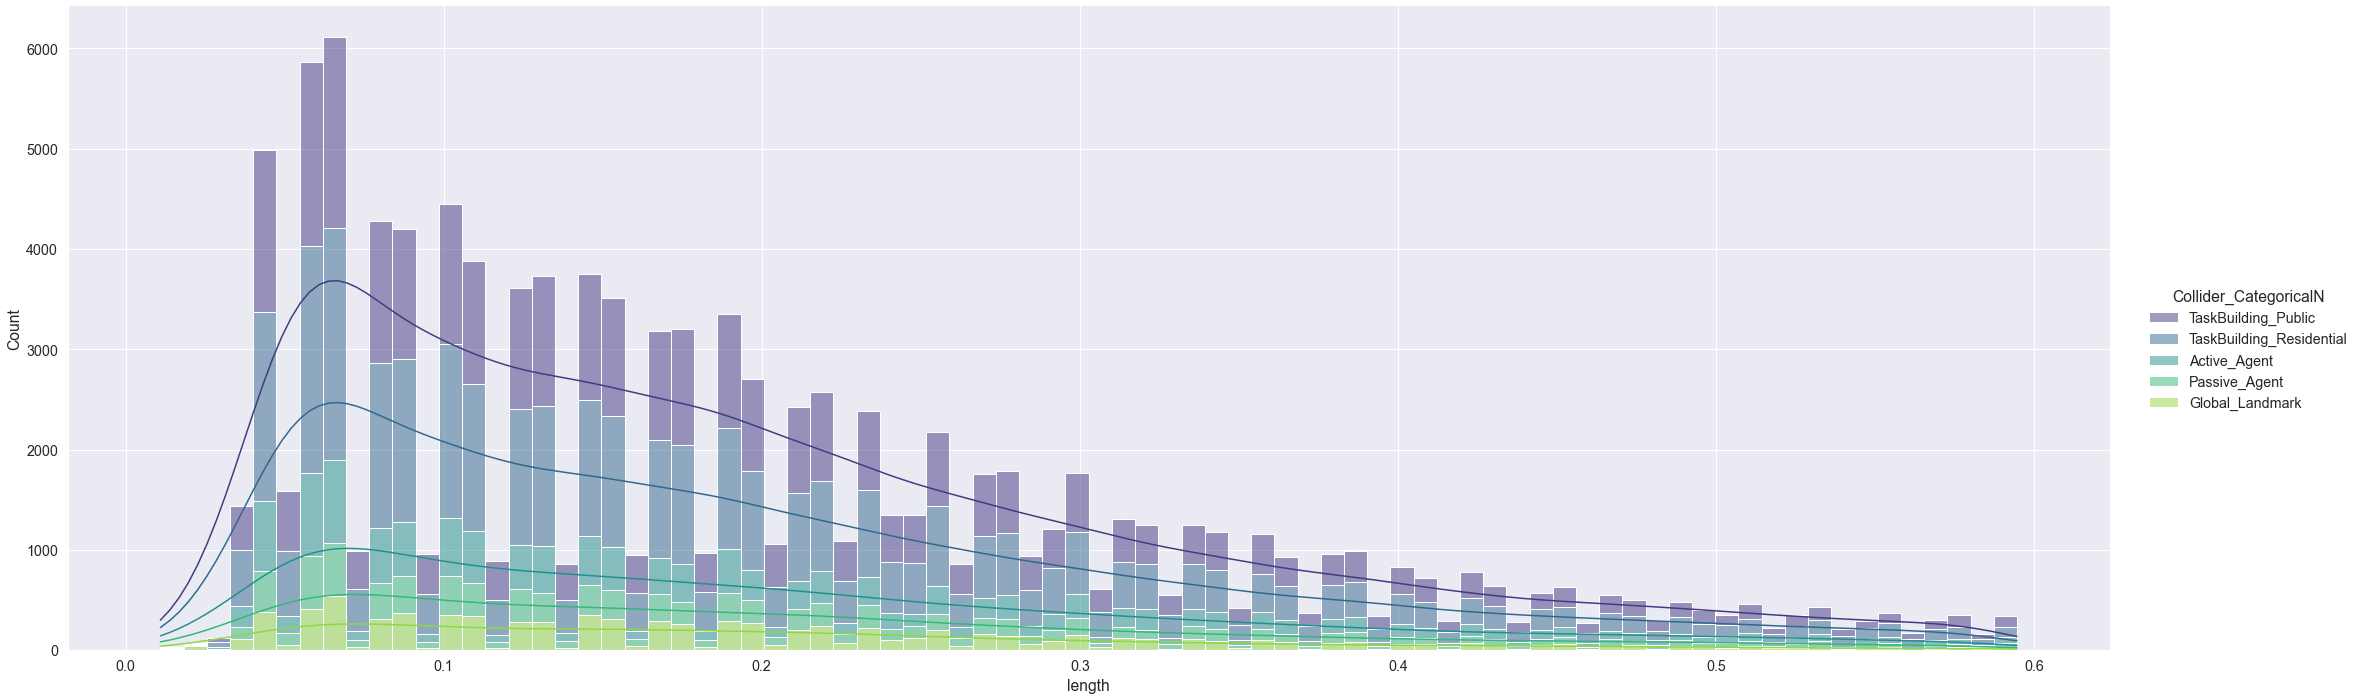

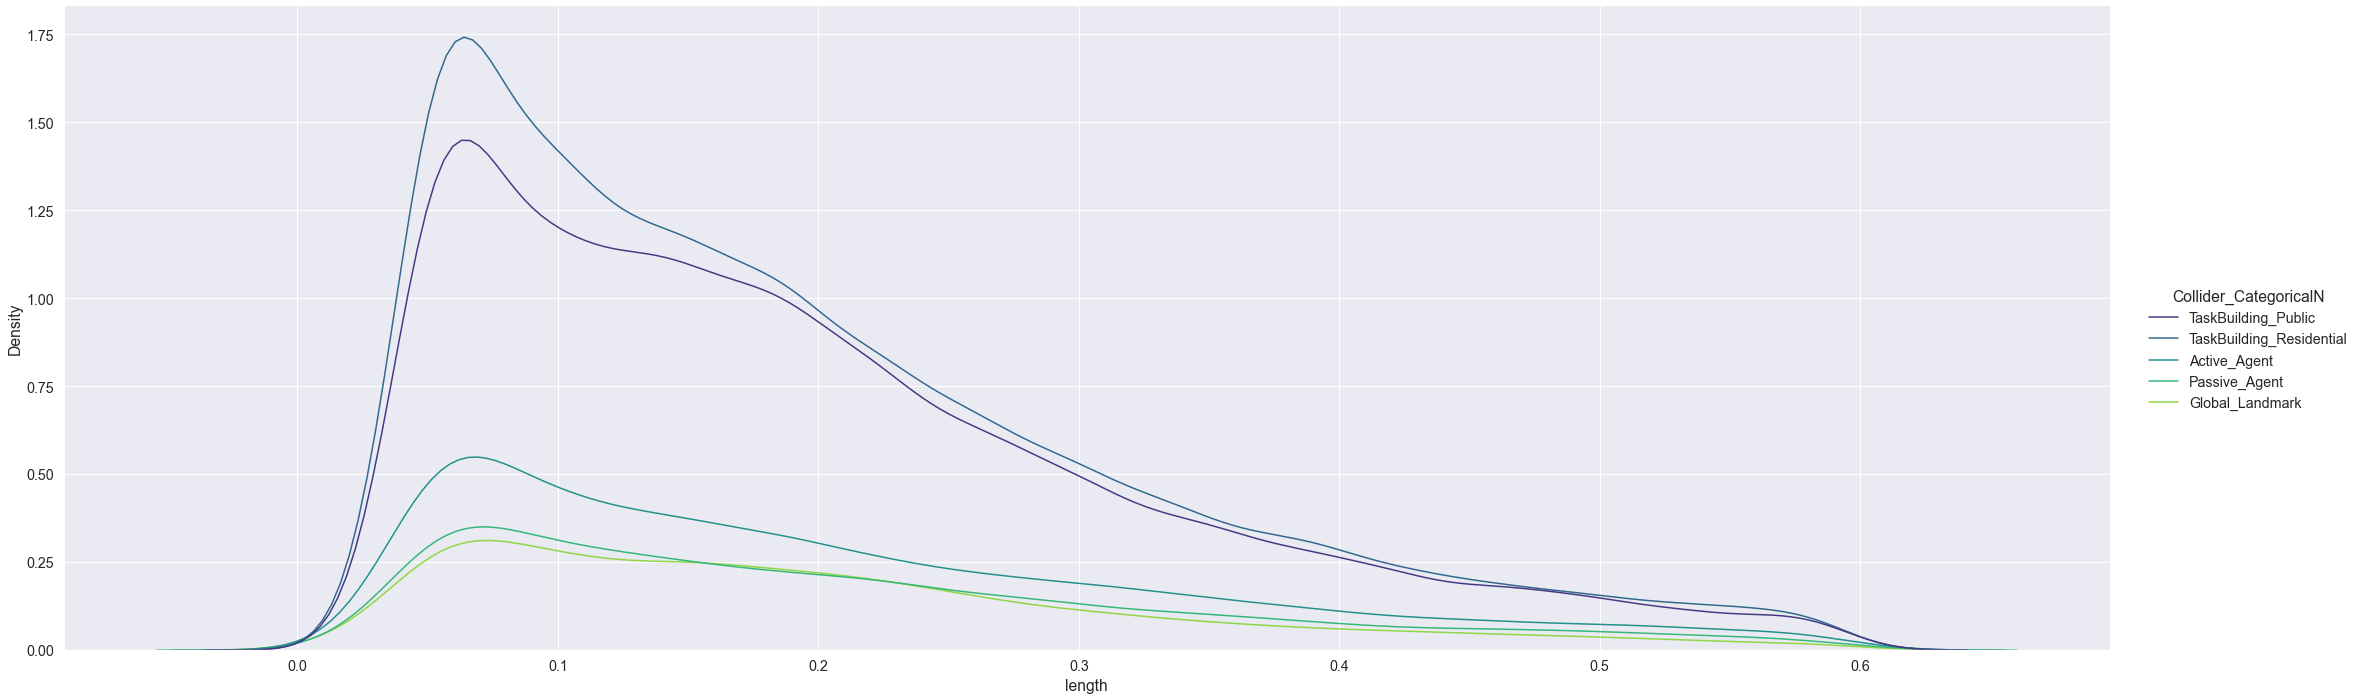

In [135]:
sns.displot(x='length', hue="Collider_CategoricalN",
             data=data_frame_gaze_no_out_ONLY_TEST, 
            height=10, aspect= 3, kde=True, palette="viridis",  multiple="stack")

sns.displot(x='length', hue="Collider_CategoricalN",
             data=data_frame_gaze_no_out_ONLY_TEST, 
            height=10, aspect= 3, kind="kde", palette="viridis")

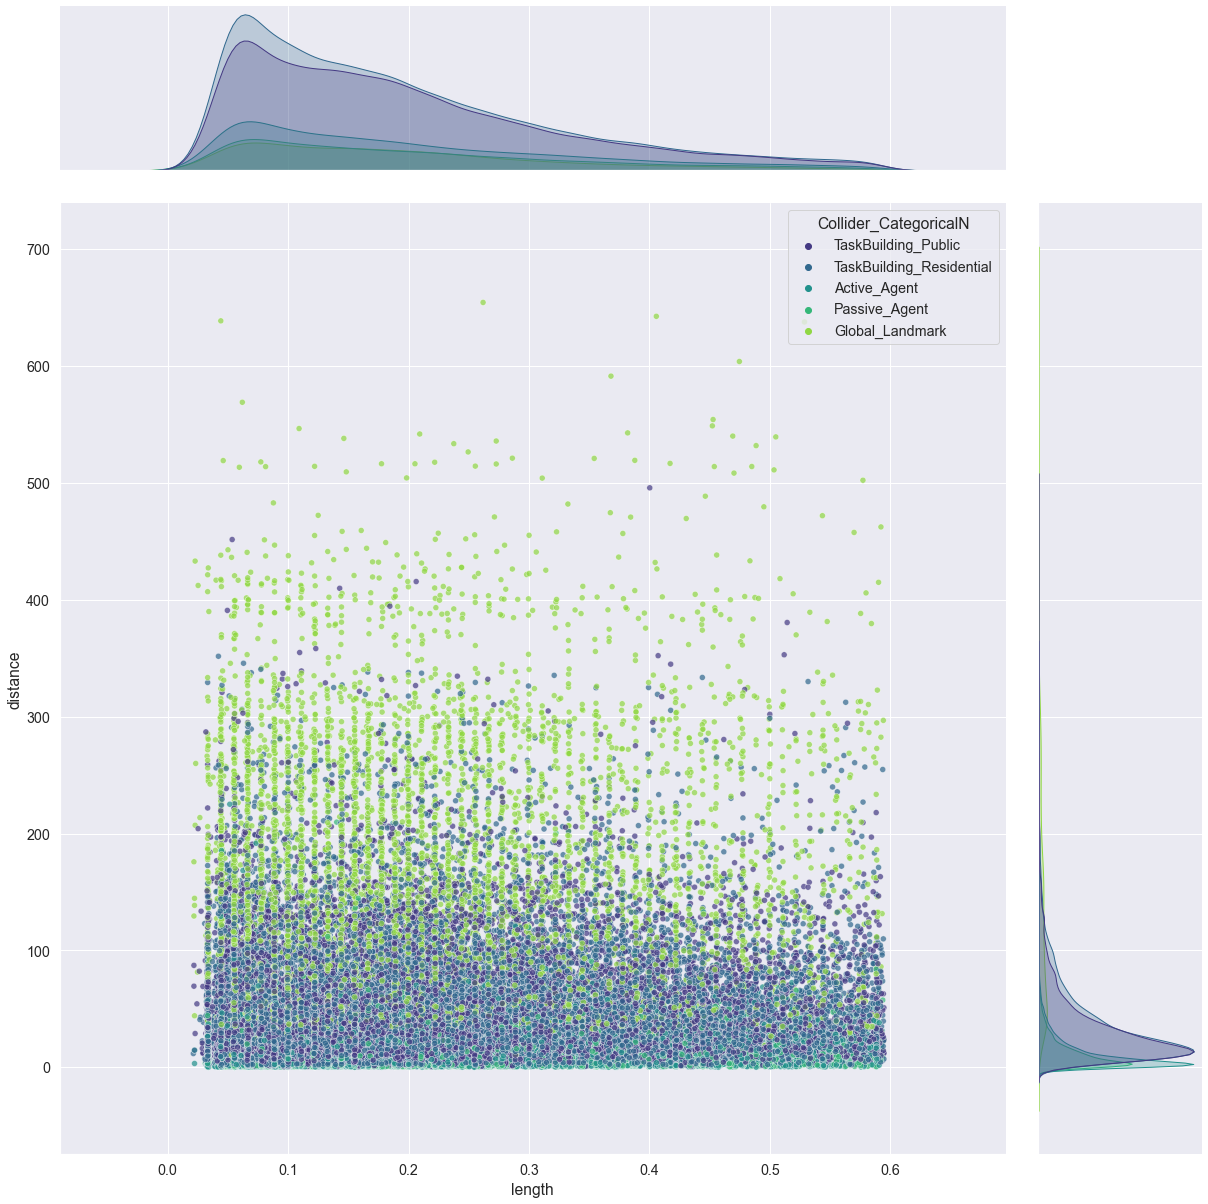

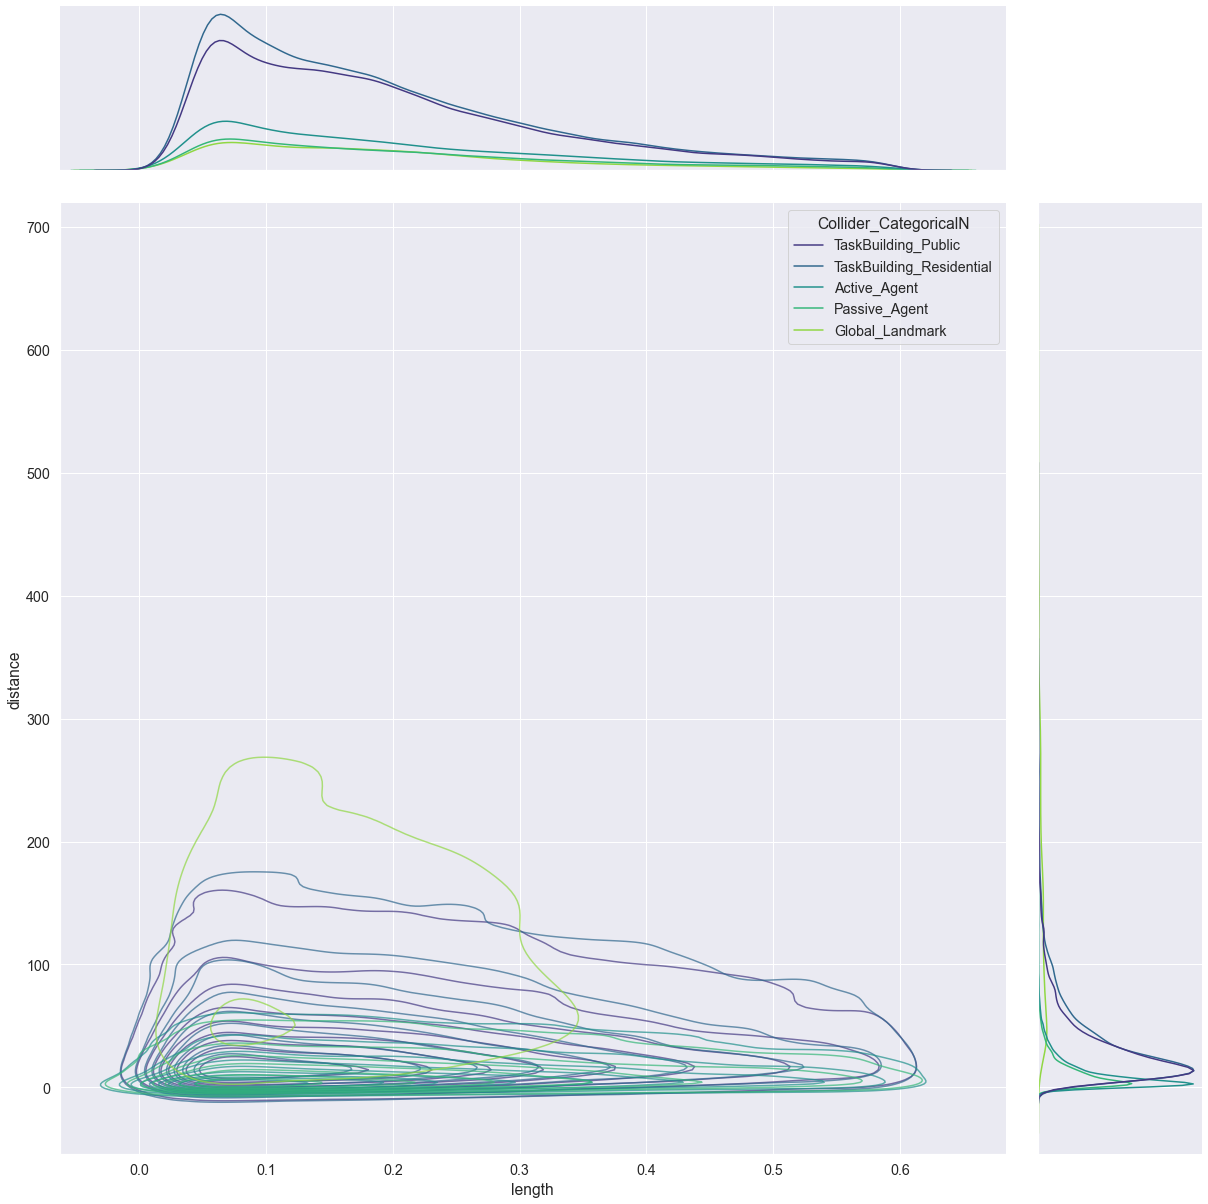

In [122]:
sns.jointplot(data=data_frame_gaze_no_out_ONLY_TEST, y="distance", x="length", hue="Collider_CategoricalN",  height=17, alpha=0.7, palette="viridis")
sns.jointplot(data=data_frame_gaze_no_out_ONLY_TEST, y="distance", x="length", hue="Collider_CategoricalN",  height=17, alpha=0.7, palette="viridis",  kind="kde")

In [142]:
# Create a Dictionary that identifies agent, graffity and house into this three categories
patterns2 = {'\d{2}_Sa':'Agent', '\d{2}_Cma':'Agent', '^TaskBuilding_': 'Building', 'BasketballCourt_58': 'Building', '^Graffity':'Graffity'}
patterns2.update(dict.fromkeys(['Castle-TaskBuilding_56', 'Crane_59','HighSilo-TaskBuilding_49', 'Windmill-TaskBuilding_10_1', 'Church-TaskBuilding_16'], 'Global_Landmark'))

In [143]:
data_frame_gaze_no_out_ONLY_TEST['Hit_Object_Category'] = data_frame_gaze_no_out_ONLY_TEST['names'].apply(lambda x: next((val for key, val in patterns2.items() if re.match(key, x)), np.nan))    

In [144]:
data_frame_gaze_no_out_ONLY_TEST = data_frame_gaze_no_out_ONLY_TEST.loc[:, ~data_frame_gaze_no_out_ONLY_TEST.columns.str.contains('^Unnamed')]
data_frame_gaze_no_out_ONLY_TEST.head()

index  SubjectID  Session  SessionSubsection  timeStampDataPointEnd  \
70      70       1031        1                  1           1.668436e+09   
217    217       1031        1                  1           1.668436e+09   
228    228       1031        1                  1           1.668436e+09   
246    246       1031        1                  1           1.668436e+09   
267    267       1031        1                  1           1.668436e+09   

     combinedGazeValidityBitmask  eyePositionCombinedWorld.x  \
70                             3                  -59.048164   
217                            3                  -59.069908   
228                            3                  -59.072449   
246                            3                  -59.089291   
267                            3                  -59.123661   

     eyePositionCombinedWorld.y  eyePositionCombinedWorld.z  \
70                     2.419450                   34.760757   
217                    2.435466                   34.760433   
228                    2.433517                   34.757622   
246                    2.427562                   34.763134   
267                    2.431819                   34.757259   

     eyeDirectionCombinedWorld.y  ...    length    distance    avg_dist  \
70                      0.017248  ...  0.171120  130.993693  130.973733   
217                     0.034346  ...  0.088288    9.926199    9.926104   
228                     0.084445  ...  0.077872   12.326112   12.320977   
246                     0.018391  ...  0.310001    7.234847    7.232347   
267                     0.340278  ...  0.311487   12.349276   12.375113   

               names     Collider_CategoricalN  Median_Standard_Duration  \
70   TaskBuilding_27       TaskBuilding_Public                  0.125027   
217  TaskBuilding_35  TaskBuilding_Residential                  0.125027   
228  TaskBuilding_35  TaskBuilding_Residential                  0.125027   
246           23_Cma              Active_Agent                  0.125027   
267      Graffity_35  TaskBuilding_Residential                  0.125027   

     gaze_mad_z Outlier_Gaze_Length Hit_Object_Category          recoded  
70     0.111002               Stays            Building  TaskBuilding_27  
217    0.551508               Stays            Building  TaskBuilding_35  
228    0.634820               Stays            Building  TaskBuilding_35  
246    1.221807               Stays               Agent           23_Cma  
267    1.233697               Stays            Graffity  TaskBuilding_35  

[5 rows x 50 columns]

### Recode to count the graffity as the house hit 

In [145]:
# Map graffity into the name of the building that it's in front of 
Graffity_mapping = {'Graffity_14':'TaskBuilding_14', 
                  'Graffity_41': 'TaskBuilding_41',
                  'Graffity_02': 'TaskBuilding_2', 
                  'Graffity_47': 'TaskBuilding_47',
                  'Graffity_20': 'TaskBuilding_20',
                  'Graffity_09': 'TaskBuilding_9',
                  'Graffity_50': 'TaskBuilding_50',
                  'Graffity_45': 'TaskBuilding_45',
                  'Graffity_08': 'TaskBuilding_8',
                  'Graffity_27': 'TaskBuilding_27',
                  'Graffity_51': 'TaskBuilding_51',
                  'Graffity_03': 'TaskBuilding_3',
                  'Graffity_11': 'TaskBuilding_11',
                  'Graffity_42': 'TaskBuilding_42',
                  'Graffity_23': 'TaskBuilding_23',
                  'Graffity_52': 'TaskBuilding_52',
                  'Graffity_38': 'TaskBuilding_38',
                  'Graffity_34': 'TaskBuilding_34',
                  'Graffity_05': 'TaskBuilding_5',
                  'Graffity_29': 'TaskBuilding_29',
                  'Graffity_32': 'TaskBuilding_32',
                  'Graffity_13': 'TaskBuilding_13',
                  'Graffity_44': 'TaskBuilding_44',
                  'Graffity_21': 'TaskBuilding_21',
                  'Graffity_04': 'TaskBuilding_4',
                  'Graffity_01': 'TaskBuilding_1',
                  'Graffity_06': 'TaskBuilding_6',
                  'Graffity_07': 'TaskBuilding_7',  
                  'Graffity_17': 'TaskBuilding_17', 
                  'Graffity_15': 'TaskBuilding_15',
                  'Graffity_12': 'TaskBuilding_12',
                  'Graffity_18': 'TaskBuilding_18',
                  'Graffity_19': 'TaskBuilding_19',
                  'Graffity_22': 'TaskBuilding_22',
                  'Graffity_24': 'TaskBuilding_24',
                  'Graffity_25': 'TaskBuilding_25',
                  'Graffity_26': 'TaskBuilding_26',
                  'Graffity_28': 'TaskBuilding_28',
                  'Graffity_30': 'TaskBuilding_30',
                  'Graffity_31': 'TaskBuilding_31',
                  'Graffity_33': 'TaskBuilding_33',
                  'Graffity_35': 'TaskBuilding_35',
                  'Graffity_36': 'TaskBuilding_36',
                  'Graffity_37': 'TaskBuilding_37',
                  'Graffity_39': 'TaskBuilding_39',
                  'Graffity_40': 'TaskBuilding_40',
                  'Graffity_43': 'TaskBuilding_43',
                  'Graffity_48': 'TaskBuilding_48',
                  'Graffity_54': 'TaskBuilding_54',
                  'Graffity_55': 'TaskBuilding_55'
             }

In [146]:
# Here we recode the literal expression on dictionary Graffity_mapping
data_frame_gaze_no_out_ONLY_TEST.loc[:, 'recoded'] = data_frame_gaze_no_out_ONLY_TEST.loc[:,'names']
data_frame_gaze_no_out_ONLY_TEST['recoded'].replace(Graffity_mapping, inplace=True)

In [147]:
data_frame_gaze_no_out_ONLY_TEST["Collider_CategoricalN"] =  data_frame_gaze_no_out_ONLY_TEST['recoded'].apply(lambda x: next((val for key, val in patterns.items() if re.match(key, x)), default_val))

## Cummulative sum calculation

In [148]:
data_frame_gaze_no_out_ONLY_TEST["cumsum_length"] = data_frame_gaze_no_out_ONLY_TEST.groupby(["SubjectID", "recoded", "Collider_CategoricalN"])['length'].cumsum()

In [127]:
data_frame_gaze_no_out_ONLY_TEST.head(20)

index  SubjectID  Session  SessionSubsection  timeStampDataPointEnd  \
70       70       1031        1                  1           1.668436e+09   
217     217       1031        1                  1           1.668436e+09   
228     228       1031        1                  1           1.668436e+09   
246     246       1031        1                  1           1.668436e+09   
267     267       1031        1                  1           1.668436e+09   
320     320       1031        1                  1           1.668436e+09   
331     331       1031        1                  1           1.668436e+09   
352     352       1031        1                  1           1.668436e+09   
557     557       1031        1                  1           1.668436e+09   
759     759       1031        1                  1           1.668436e+09   
766     766       1031        1                  1           1.668436e+09   
825     825       1031        1                  1           1.668436e+09   
1297   1297       1031        1                  1           1.668436e+09   
1433   1433       1031        1                  1           1.668436e+09   
1499   1499       1031        1                  1           1.668436e+09   
1599   1599       1031        1                  1           1.668436e+09   
1660   1660       1031        1                  1           1.668436e+09   
1690   1690       1031        1                  1           1.668436e+09   
2041   2041       1031        1                  1           1.668436e+09   
2087   2087       1031        1                  1           1.668436e+09   

      combinedGazeValidityBitmask  eyePositionCombinedWorld.x  \
70                              3                  -59.048164   
217                             3                  -59.069908   
228                             3                  -59.072449   
246                             3                  -59.089291   
267                             3                  -59.123661   
320                             3                  -59.018215   
331                             3                  -59.008221   
352                             3                  -59.017628   
557                             3                  -59.027905   
759                             3                  -54.562382   
766                             3                  -54.198807   
825                             3                  -51.105637   
1297                            3                  -23.291555   
1433                            3                  -18.478300   
1499                            3                  -17.304085   
1599                            3                  -10.266352   
1660                            3                   -6.067479   
1690                            3                   -5.665334   
2041                            3                   12.102761   
2087                            3                   15.534870   

      eyePositionCombinedWorld.y  eyePositionCombinedWorld.z  \
70                      2.419450                   34.760757   
217                     2.435466                   34.760433   
228                     2.433517                   34.757622   
246                     2.427562                   34.763134   
267                     2.431819                   34.757259   
320                     2.443910                   34.757027   
331                     2.444259                   34.758366   
352                     2.442195                   34.763046   
557                     2.416220                   34.782959   
759                     2.427841                   38.617199   
766                     2.419990                   38.704857   
825                     2.370979                   39.597641   
1297                    2.181413                   48.696072   
1433                    2.155131                   50.725342   
1499                    2.174297                   51.258060  

In [149]:
data_frame_gaze_no_out_ONLY_TEST[["length", "recoded", "cumsum_length"]] 

length                     recoded  cumsum_length
70        0.171120             TaskBuilding_27       0.171120
217       0.088288             TaskBuilding_35       0.088288
228       0.077872             TaskBuilding_35       0.166160
246       0.310001                      23_Cma       0.310001
267       0.311487             TaskBuilding_35       0.477648
...            ...                         ...            ...
14211902  0.420612  Windmill-TaskBuilding_10_1      30.904855
14212752  0.110609  Windmill-TaskBuilding_10_1      31.015463
14212755  0.044640  Windmill-TaskBuilding_10_1      31.060104
14212766  0.100689  Windmill-TaskBuilding_10_1      31.160792
14214227  0.212290             TaskBuilding_18      14.021962

[114950 rows x 3 columns]

In [34]:
data_frame_gaze_no_out_ONLY_TEST.cumsum_length.describe()

count    114950.000000
mean          8.186959
std           7.762038
min           0.012399
25%           2.545770
50%           6.025876
75%          11.397074
max          61.142519
Name: cumsum_length, dtype: float64

In [150]:
Dwelling_time = pd.DataFrame(data_frame_gaze_no_out_ONLY_TEST.groupby(["SubjectID","recoded","Collider_CategoricalN"])["cumsum_length"].max())
Dwelling_time.reset_index(inplace=True)
Count = pd.DataFrame(data_frame_gaze_no_out_ONLY_TEST.groupby(["SubjectID","recoded","Collider_CategoricalN"])["cumsum_length"].count())
Count.reset_index(inplace=True)
Fixations = Dwelling_time.merge(Count, on=["SubjectID", "recoded","Collider_CategoricalN"])
Fixations.rename({"cumsum_length_x": "Dwelling_Time", "cumsum_length_y":"Fixation_Count"}, axis=1, inplace=True)

In [151]:
Fixations

SubjectID                     recoded     Collider_CategoricalN  \
0          1031                      01_Cma              Active_Agent   
1          1031                      02_Cma              Active_Agent   
2          1031                      03_Cma              Active_Agent   
3          1031                      04_Cma              Active_Agent   
4          1031                      05_Cma              Active_Agent   
...         ...                         ...                       ...   
2748       9627              TaskBuilding_6  TaskBuilding_Residential   
2749       9627              TaskBuilding_7  TaskBuilding_Residential   
2750       9627              TaskBuilding_8       TaskBuilding_Public   
2751       9627              TaskBuilding_9       TaskBuilding_Public   
2752       9627  Windmill-TaskBuilding_10_1           Global_Landmark   

      Dwelling_Time  Fixation_Count  
0          7.795758              39  
1          0.620509               6  
2          5.063690              26  
3          1.016814               3  
4          4.783982              21  
...             ...             ...  
2748       8.768292              51  
2749       6.325496              26  
2750      10.597064              59  
2751       9.779672              48  
2752      31.160792             144  

[2753 rows x 5 columns]

In [152]:
Fixations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2753 entries, 0 to 2752
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SubjectID              2753 non-null   int64  
 1   recoded                2753 non-null   object 
 2   Collider_CategoricalN  2753 non-null   object 
 3   Dwelling_Time          2753 non-null   float64
 4   Fixation_Count         2753 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 129.0+ KB


### Sanity check: Make sure that the cummulative sum equals the same as the raw length 

In [48]:
Fixation_sum = pd.DataFrame(Fixations.groupby(["SubjectID"])["Dwelling_Time"].sum())
Fixation_sum.reset_index(inplace=True)
Fixation_sum.loc[:, "Minutes"] = (Fixation_sum.Dwelling_Time)/60
Fixation_sum.loc[:, "Hours"] = (Fixation_sum.Minutes)/60
Fixation_sum

SubjectID  Dwelling_Time    Minutes     Hours
0        1031    1005.179596  16.752993  0.279217
1        1268     963.920926  16.065349  0.267756
2        1574     871.204033  14.520067  0.242001
3        1843     717.187108  11.953118  0.199219
4        2069     799.570702  13.326178  0.222103
5        3193    1049.050746  17.484179  0.291403
6        3540     420.721649   7.012027  0.116867
7        4580     752.052089  12.534201  0.208903
8        4598    1055.083677  17.584728  0.293079
9        4847     804.771146  13.412852  0.223548
10       4875     955.580119  15.926335  0.265439
11       5161    1226.259322  20.437655  0.340628
12       5189     971.908340  16.198472  0.269975
13       5743    1051.128044  17.518801  0.291980
14       5766     893.854380  14.897573  0.248293
15       5851     758.780397  12.646340  0.210772
16       5972     986.253256  16.437554  0.273959
17       6406     924.374731  15.406246  0.256771
18       7081     684.161948  11.402699  0.190045
19       7393    1094.614307  18.243572  0.304060
20       7823     847.779296  14.129655  0.235494
21       7935     533.544173   8.892403  0.148207
22       8629    1148.346511  19.139109  0.318985
23       9297    1281.718537  21.361976  0.356033
24       9627     850.415159  14.173586  0.236226

In [49]:
Complete_Sum = pd.DataFrame(data_frame_gaze_no_out_ONLY_TEST.groupby(["SubjectID"])["length"].sum())
Complete_Sum.reset_index(inplace=True)
Complete_Sum.loc[:, "Minutes"] = (Complete_Sum.length)/60
Complete_Sum.loc[:, "Hours"] = (Complete_Sum.Minutes)/60
Complete_Sum

SubjectID       length    Minutes     Hours
0        1031  1005.179596  16.752993  0.279217
1        1268   963.920926  16.065349  0.267756
2        1574   871.204033  14.520067  0.242001
3        1843   717.187108  11.953118  0.199219
4        2069   799.570702  13.326178  0.222103
5        3193  1049.050746  17.484179  0.291403
6        3540   420.721649   7.012027  0.116867
7        4580   752.052089  12.534201  0.208903
8        4598  1055.083677  17.584728  0.293079
9        4847   804.771146  13.412852  0.223548
10       4875   955.580119  15.926335  0.265439
11       5161  1226.259322  20.437655  0.340628
12       5189   971.908340  16.198472  0.269975
13       5743  1051.128044  17.518801  0.291980
14       5766   893.854380  14.897573  0.248293
15       5851   758.780397  12.646340  0.210772
16       5972   986.253256  16.437554  0.273959
17       6406   924.374731  15.406246  0.256771
18       7081   684.161948  11.402699  0.190045
19       7393  1094.614307  18.243572  0.304060
20       7823   847.779296  14.129655  0.235494
21       7935   533.544173   8.892403  0.148207
22       8629  1148.346511  19.139109  0.318985
23       9297  1281.718537  21.361976  0.356033
24       9627   850.415159  14.173586  0.236226

In [153]:
TaskBuildings_GL = Fixations.loc[(Fixations.recoded.str.match('^TaskBuilding_')) | (Fixations.Collider_CategoricalN == 'Global_Landmark') ]
order_buildings = pd.DataFrame(TaskBuildings_GL.groupby("recoded")["Dwelling_Time"].median().sort_values(ascending=False))
Agents = Fixations.loc[Fixations.Collider_CategoricalN.str.contains("Agent")]
order_agents = pd.DataFrame(Agents.groupby("recoded")["Dwelling_Time"].median().sort_values(ascending=False))

In [154]:
Agents

SubjectID recoded Collider_CategoricalN  Dwelling_Time  Fixation_Count
0          1031  01_Cma          Active_Agent       7.795758              39
1          1031  02_Cma          Active_Agent       0.620509               6
2          1031  03_Cma          Active_Agent       5.063690              26
3          1031  04_Cma          Active_Agent       1.016814               3
4          1031  05_Cma          Active_Agent       4.783982              21
...         ...     ...                   ...            ...             ...
2691       9627   52_Sa         Passive_Agent       0.978113               4
2692       9627   53_Sa         Passive_Agent       0.552046               2
2693       9627   54_Sa         Passive_Agent       0.661171               3
2694       9627   55_Sa         Passive_Agent       1.131379               7
2695       9627   56_Sa         Passive_Agent       0.178065               1

[1329 rows x 5 columns]

### Visualization of Dweling-Times (AKA. cummulative sums) 

In [155]:
Fixations[['Dwelling_Time', 'Fixation_Count']].corr().style.background_gradient(cmap="viridis")

<AxesSubplot: xlabel='Fixation_Count', ylabel='Dwelling_Time'>

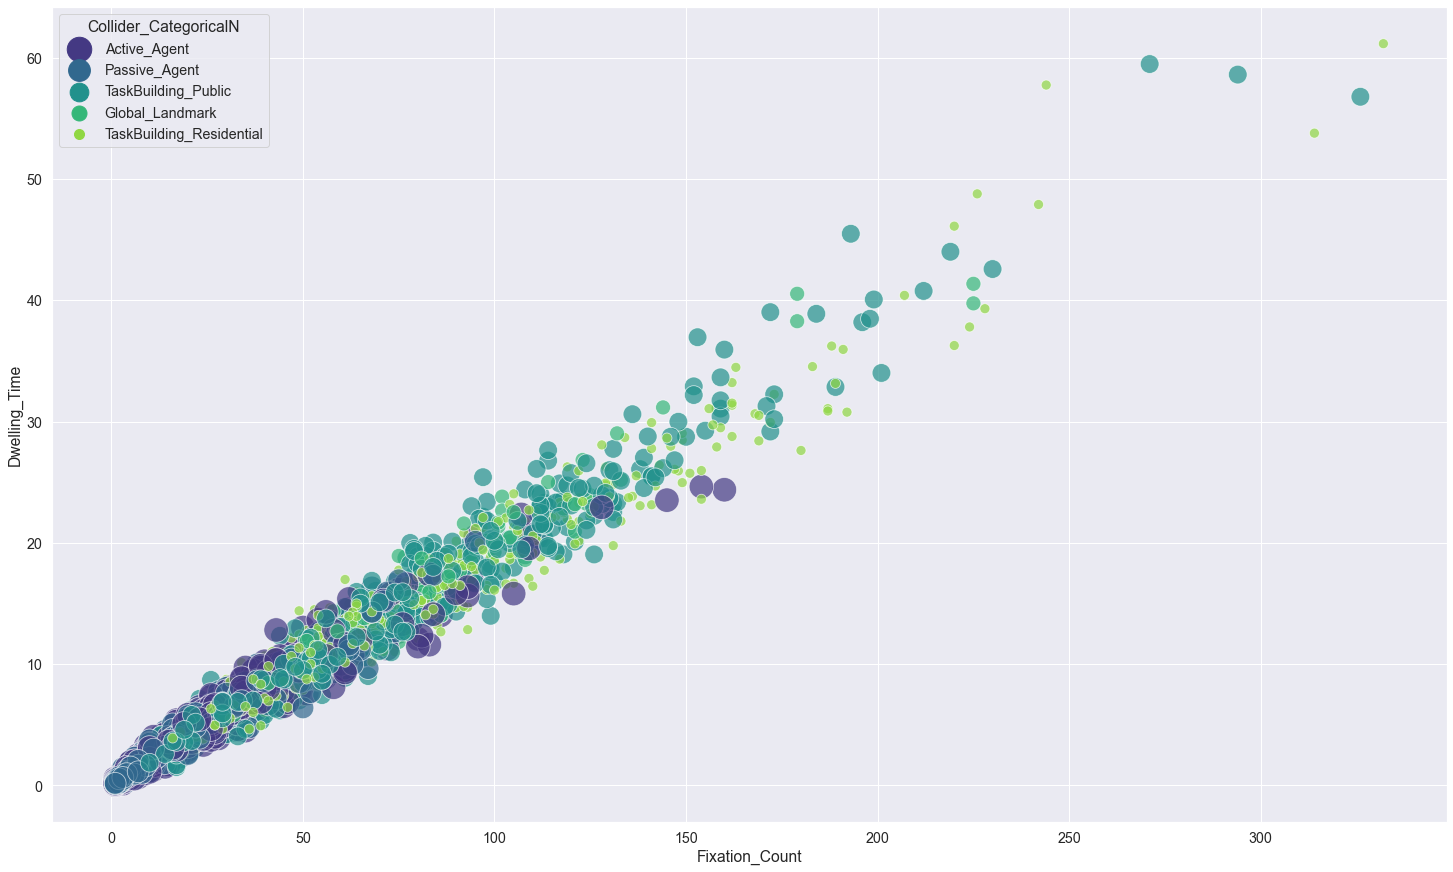

In [64]:
plt.figure(figsize=(25,15))
sns.set(font_scale = 1.3)
sns.scatterplot(x='Fixation_Count', y='Dwelling_Time', hue="Collider_CategoricalN",
                size="Collider_CategoricalN", sizes=(100,600), legend="full", data=Fixations, alpha=0.7, palette="viridis")

<Figure size 1800x1080 with 0 Axes>

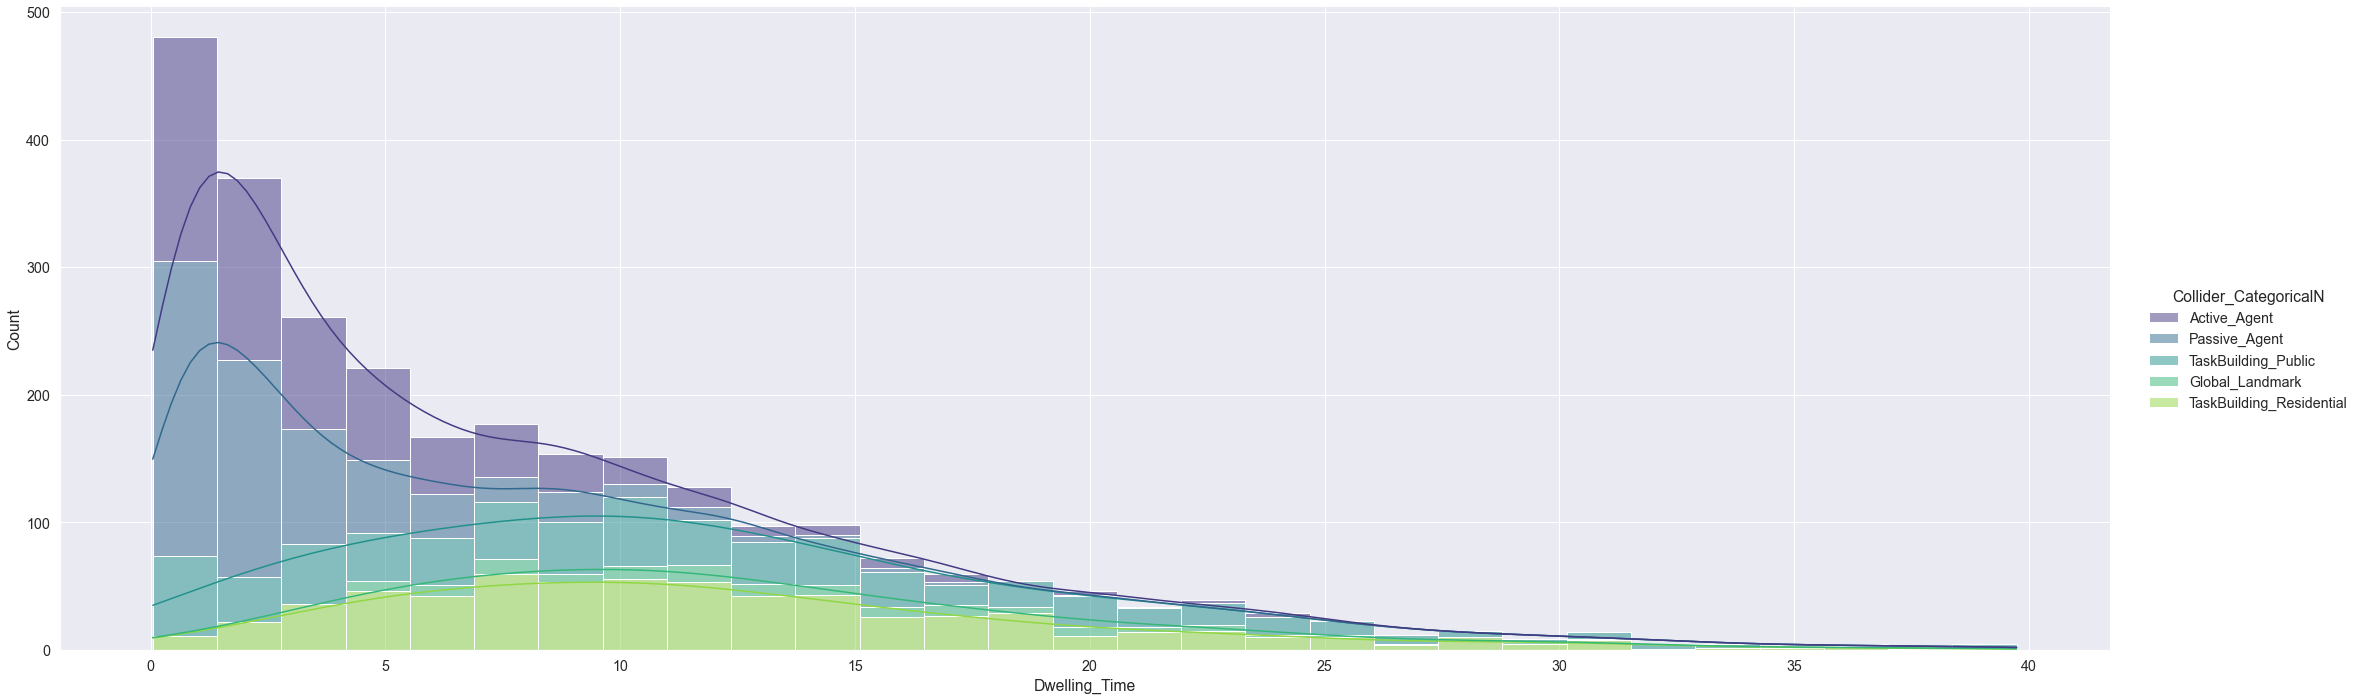

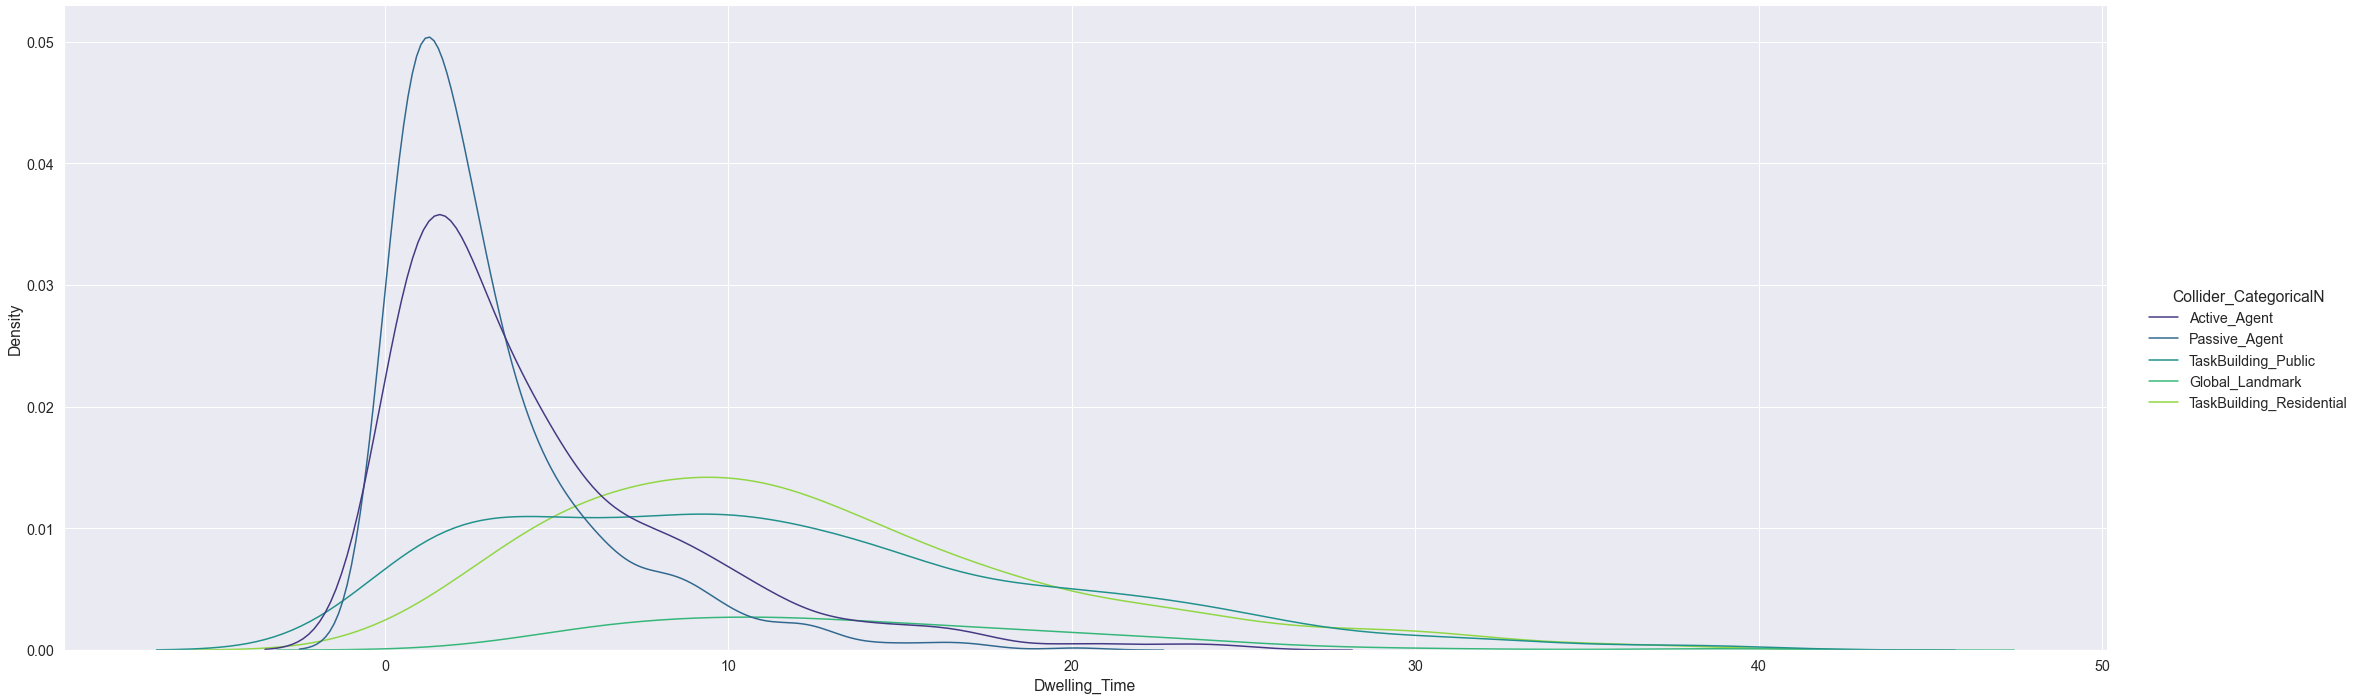

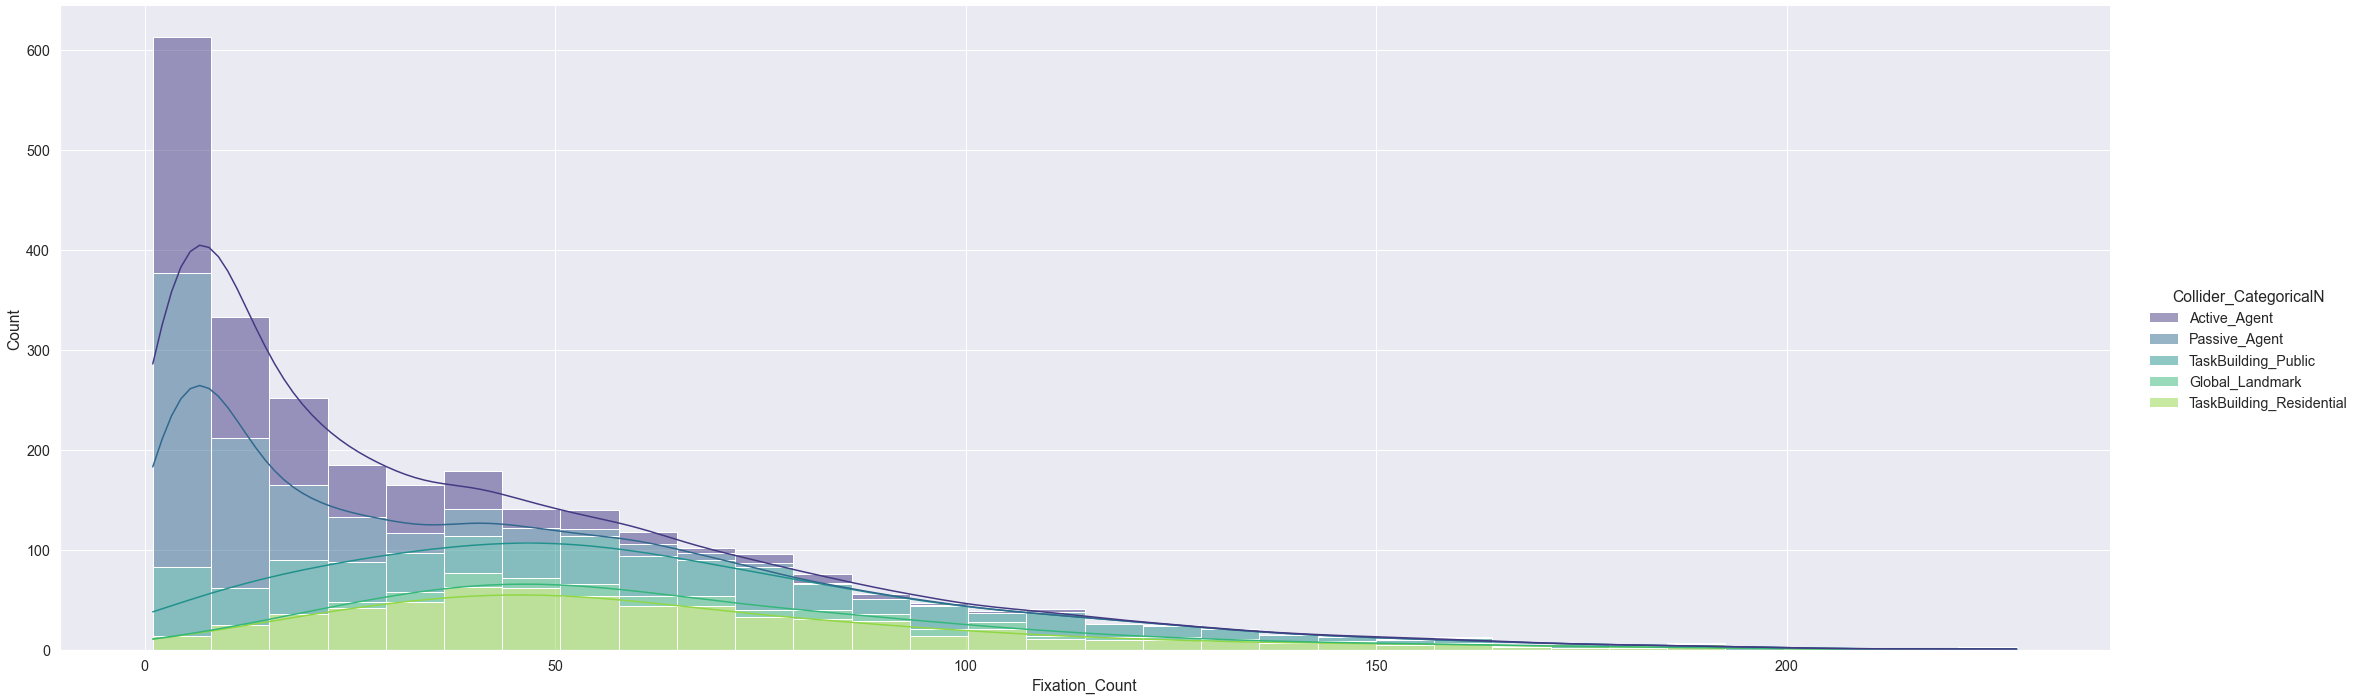

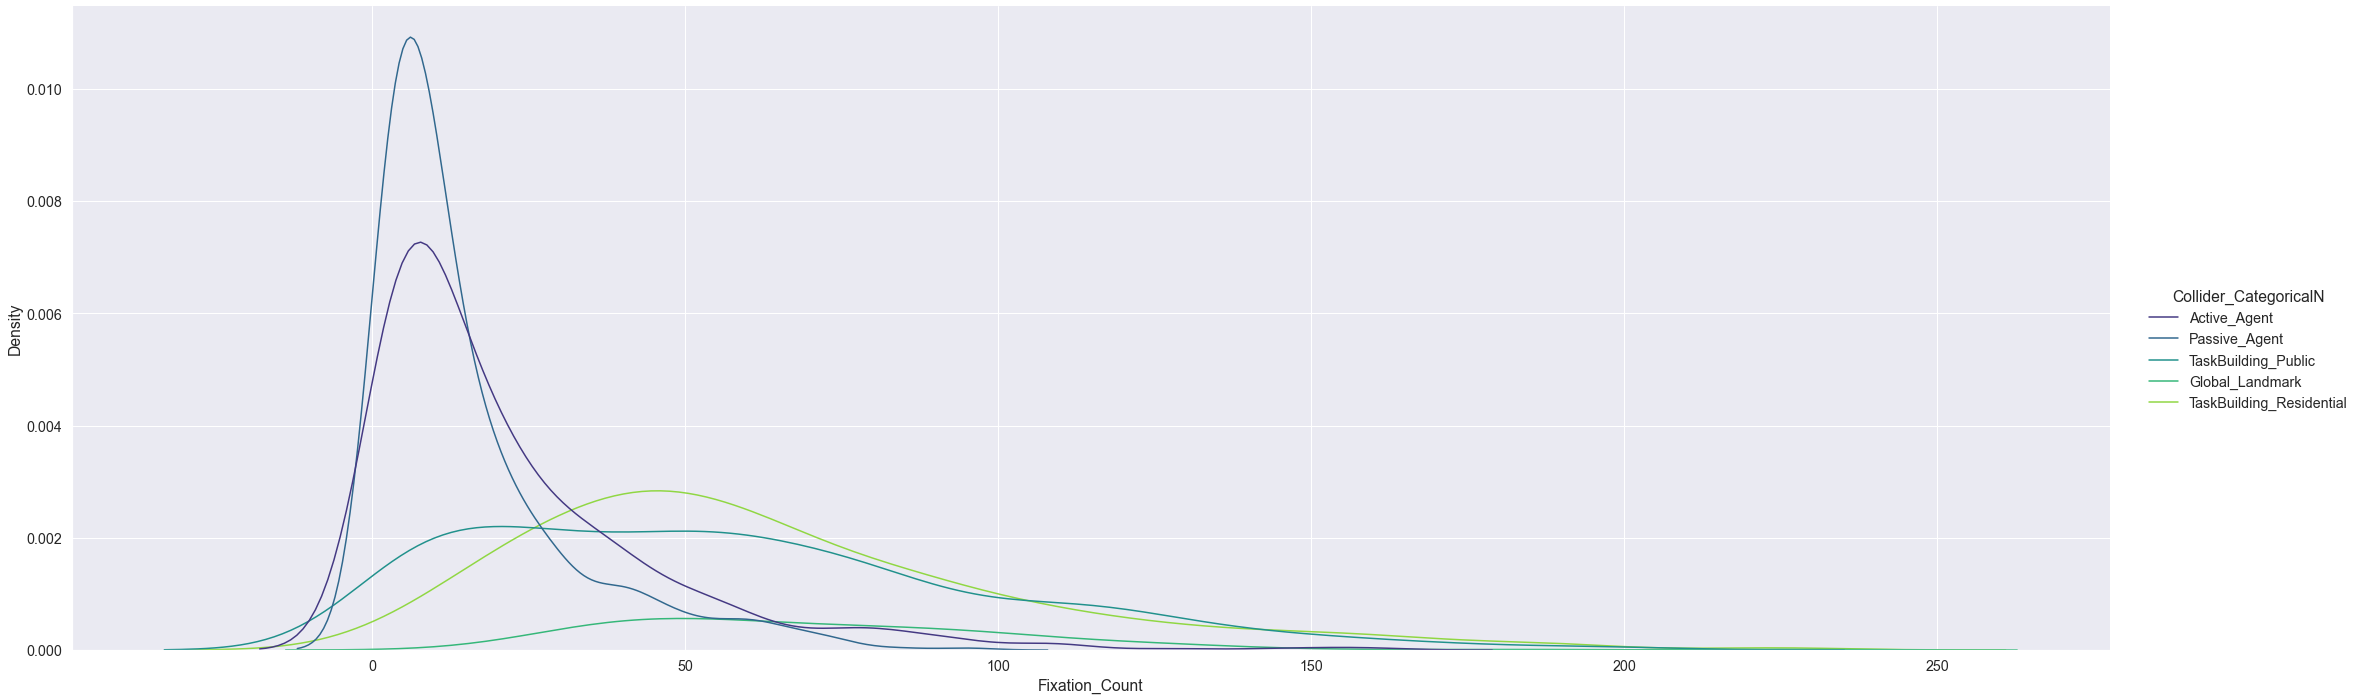

In [65]:
plt.figure(figsize=(25,15))
sns.set(font_scale = 1.3)
sns.displot(x='Dwelling_Time', hue="Collider_CategoricalN",
             data=Fixations[Fixations.Dwelling_Time < 40], 
            height=10, aspect= 3, kde=True, palette="viridis",  multiple="stack")

sns.displot(x='Dwelling_Time', hue="Collider_CategoricalN",
             data=Fixations[Fixations.Dwelling_Time < 40], 
            height=10, aspect= 3, kind="kde", palette="viridis")

sns.displot(x='Fixation_Count', hue="Collider_CategoricalN",
             data=Fixations[Fixations.Dwelling_Time < 40], 
            height=10, aspect= 3, kde=True, palette="viridis",  multiple="stack")

sns.displot(x='Fixation_Count', hue="Collider_CategoricalN",
             data=Fixations[Fixations.Dwelling_Time < 40], 
            height=10, aspect= 3, kind="kde", palette="viridis")

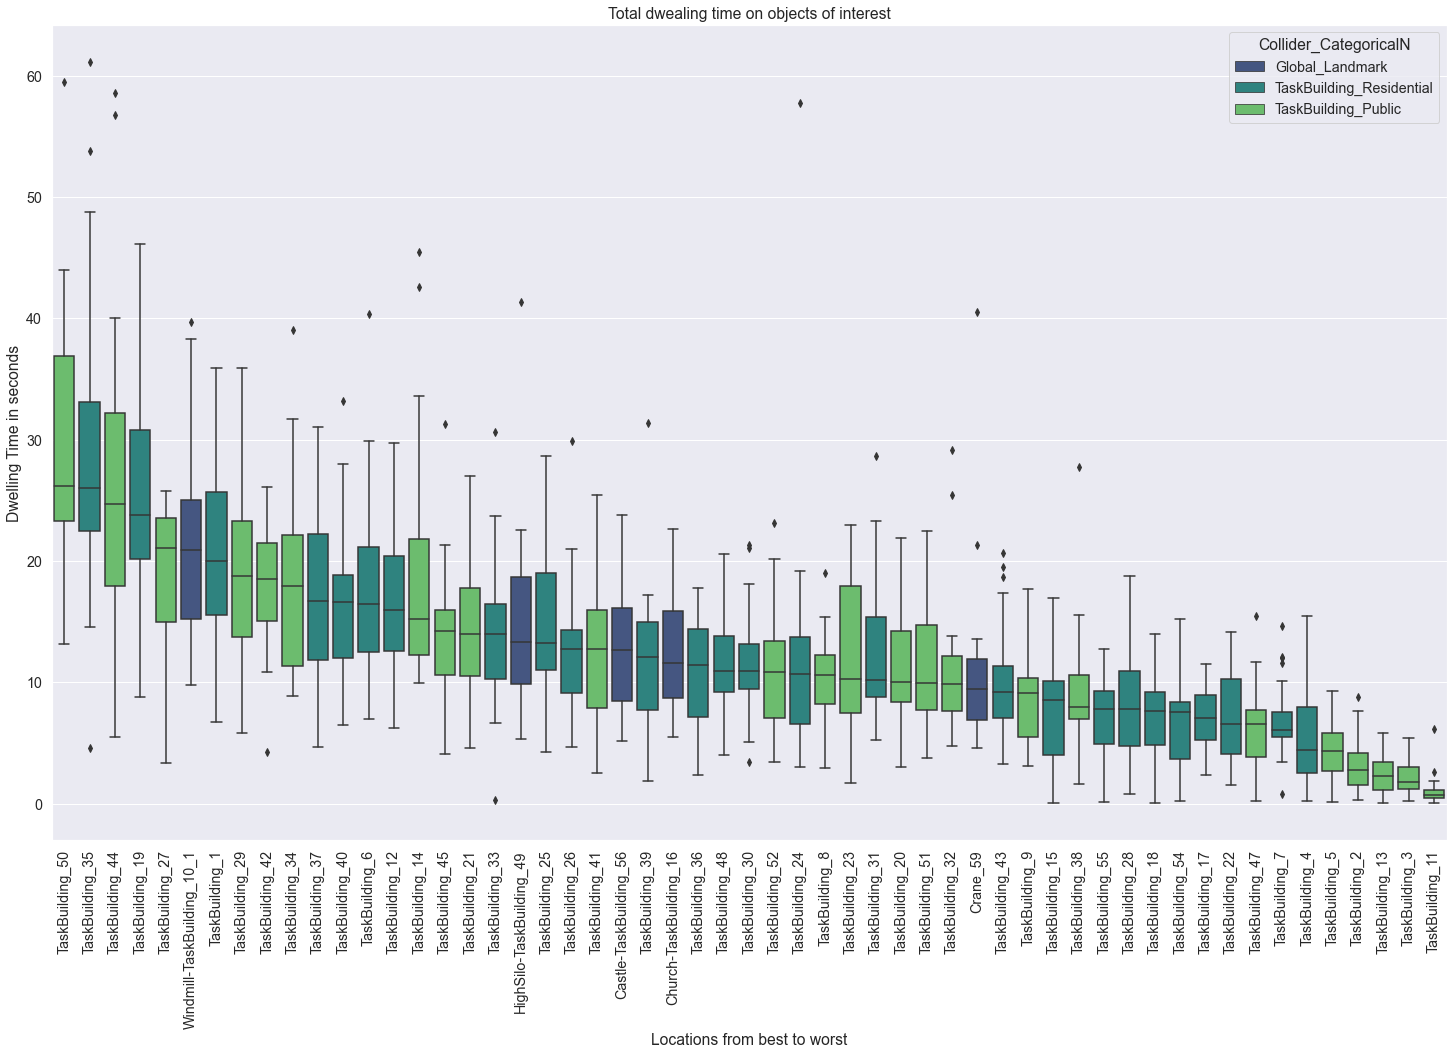

In [66]:
plt.figure(figsize=(25,15))
a = sns.boxplot(x='recoded', y='Dwelling_Time', dodge=False, hue="Collider_CategoricalN", order= order_buildings.index.values, data=TaskBuildings_GL, palette="viridis")
plt.title('Total dwealing time on objects of interest')
plt.xlabel('Locations from best to worst')
plt.ylabel('Dwelling Time in seconds')
plt.xticks(rotation=90);

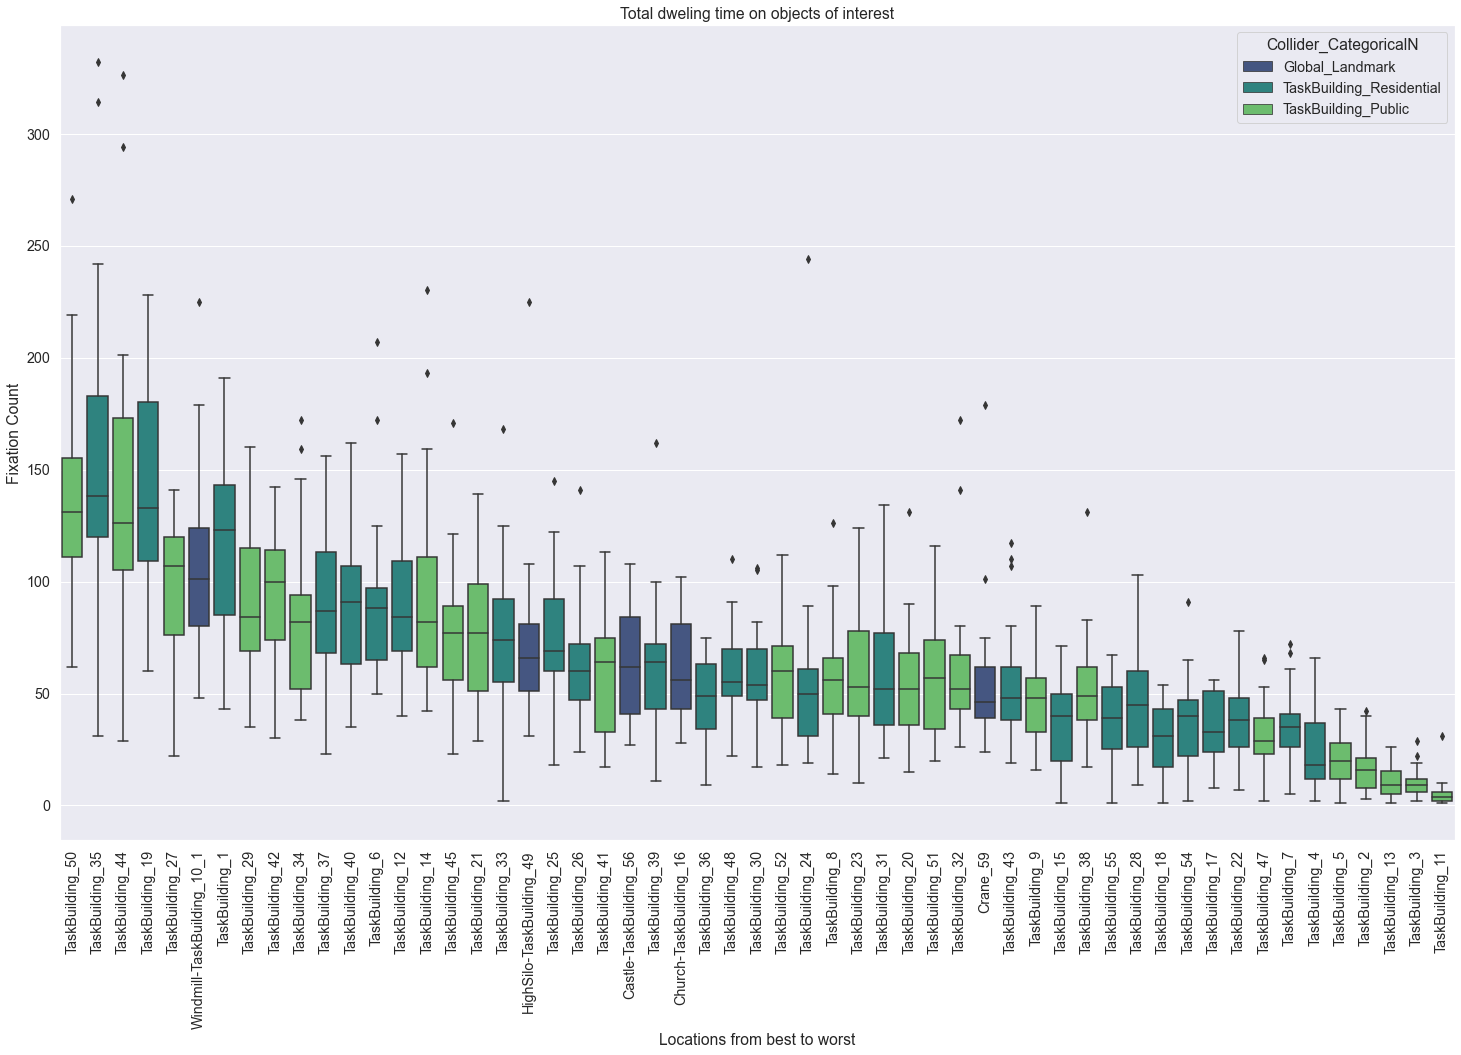

In [61]:
plt.figure(figsize=(25,15))
a = sns.boxplot(x='recoded', y='Fixation_Count', dodge=False, hue="Collider_CategoricalN", order= order_buildings.index.values, data=TaskBuildings_GL, palette="viridis")
plt.title('Total dweling time on objects of interest')
plt.xlabel('Locations from best to worst')
plt.ylabel('Fixation Count')
plt.xticks(rotation=90);

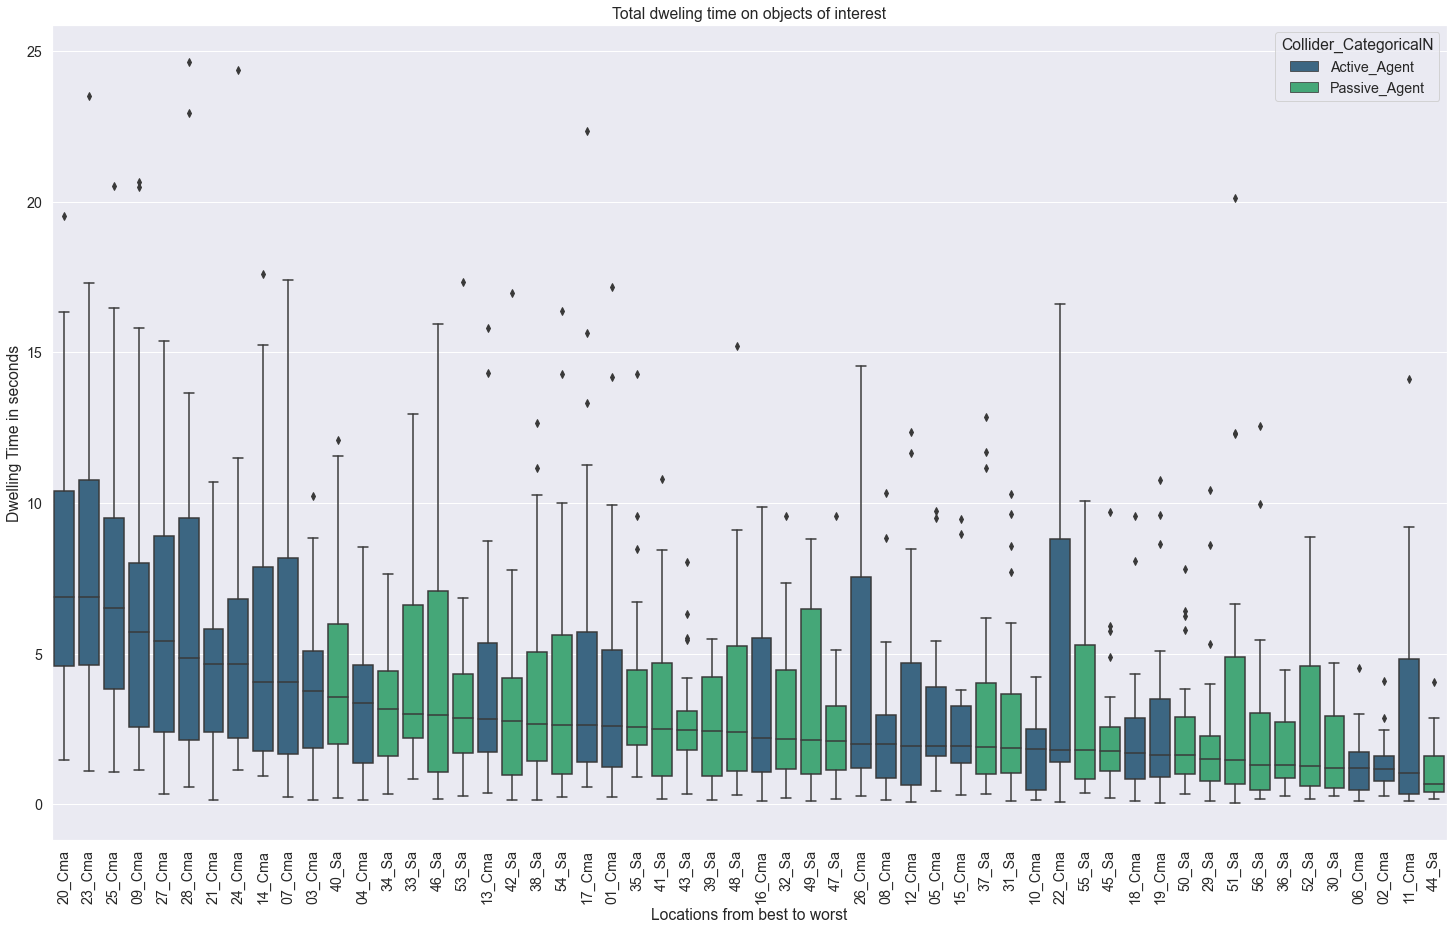

In [62]:
plt.figure(figsize=(25,15))
a = sns.boxplot(x='recoded', y='Dwelling_Time', dodge=False, hue="Collider_CategoricalN", order= order_agents.index.values, data=Agents, palette="viridis")
plt.title('Total dweling time on objects of interest')
plt.xlabel('Locations from best to worst')
plt.ylabel('Dwelling Time in seconds')
plt.xticks(rotation=90);

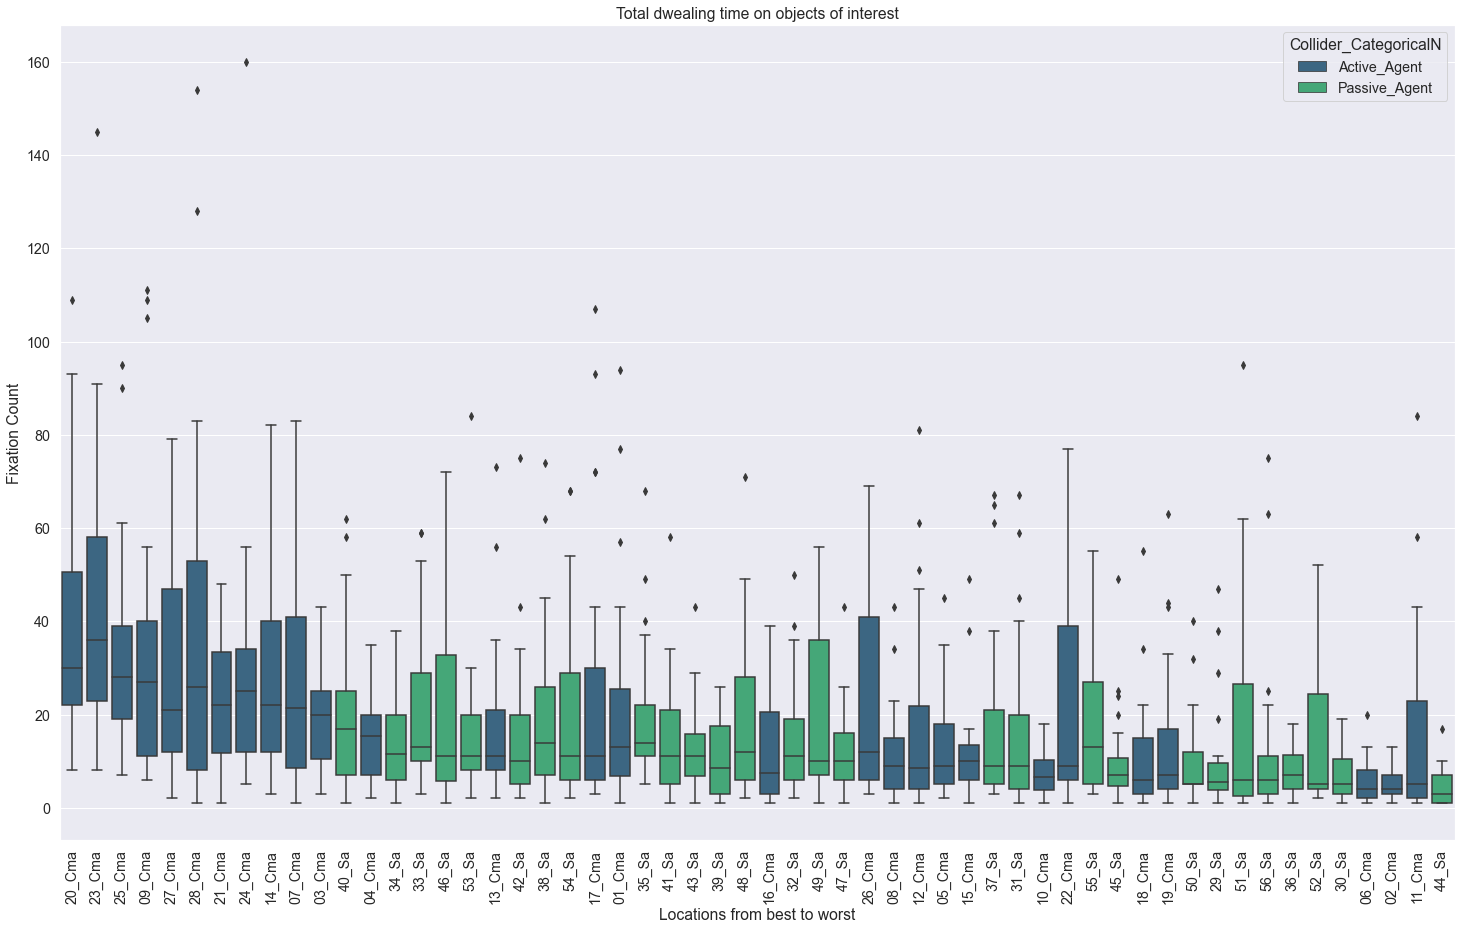

In [145]:
plt.figure(figsize=(25,15))
a = sns.boxplot(x='recoded', y='Fixation_Count', dodge=False, hue="Collider_CategoricalN", order= order_agents.index.values, data=Agents, palette="viridis")
plt.title('Total dwealing time on objects of interest')
plt.xlabel('Locations from best to worst')
plt.ylabel('Fixation Count')
plt.xticks(rotation=90);

## Preparation for the merging of behavioral data with Dwelling times 

In [156]:
# Create a dictionary that identifies: Agent, Building, and graffity with one ID
patterns1 = {'^01_Cma$':1}
patterns1.update(dict.fromkeys(['^TaskBuilding_14$','^Graffity_14$'], 1))
patterns1.update(dict.fromkeys(['^02_Cma$','^TaskBuilding_41$','^Graffity_41$'], 2))
patterns1.update(dict.fromkeys(['^03_Cma$','^TaskBuilding_2$', '^Graffity_02$'], 3))
patterns1.update(dict.fromkeys(['^04_Cma$','^TaskBuilding_47$','^Graffity_47$'], 4))
patterns1.update(dict.fromkeys(['^05_Cma$','^Construction_57$'], 5))
patterns1.update(dict.fromkeys(['^06_Cma$','^TaskBuilding_20$','^Graffity_20$'], 6))
patterns1.update(dict.fromkeys(['^07_Cma$','^TaskBuilding_9$','^Graffity_09$'], 7))
patterns1.update(dict.fromkeys(['^08_Cma$','^TaskBuilding_50$','^Graffity_50$'], 8))
patterns1.update(dict.fromkeys(['^09_Cma$','^TaskBuilding_45$','^Graffity_45$'], 9))
patterns1.update(dict.fromkeys(['^10_Cma$','^TaskBuilding_8$','^Graffity_08$'], 10))
patterns1.update(dict.fromkeys(['^11_Cma$','^TaskBuilding_27$','^Graffity_27$'], 11))
patterns1.update(dict.fromkeys(['^12_Cma$','^TaskBuilding_51$','^Graffity_51$'], 12))
patterns1.update(dict.fromkeys(['^13_Cma$','^TaskBuilding_3$','^Graffity_03$'], 13))
patterns1.update(dict.fromkeys(['^14_Cma$','^TaskBuilding_11$','^Graffity_11$'], 14))
patterns1.update(dict.fromkeys(['^15_Cma$','^TaskBuilding_42$','^Graffity_42$'], 15))
patterns1.update(dict.fromkeys(['^16_Cma$','^TaskBuilding_23$','^Graffity_23$'], 16))
patterns1.update(dict.fromkeys(['^17_Cma$','^TaskBuilding_52$','^Graffity_52$'], 17))
patterns1.update(dict.fromkeys(['^18_Cma$','^TaskBuilding_38$','^Graffity_38$'], 18))
patterns1.update(dict.fromkeys(['^19_Cma$','^TaskBuilding_34$','^Graffity_34$'], 19))
patterns1.update(dict.fromkeys(['^20_Cma$','^BasketballCourt_58$'], 20))
patterns1.update(dict.fromkeys(['^21_Cma$','^TaskBuilding_5$','^Graffity_05$'], 21))
patterns1.update(dict.fromkeys(['^22_Cma$','^TaskBuilding_29$','^Graffity_29$'], 22))
patterns1.update(dict.fromkeys(['^23_Cma$','^TaskBuilding_32$','^Graffity_32$'], 23))
patterns1.update(dict.fromkeys(['^24_Cma$','^TaskBuilding_13$','^Graffity_13$'], 24))
patterns1.update(dict.fromkeys(['^25_Cma$','^TaskBuilding_44$','^Graffity_44$'], 25))
patterns1.update(dict.fromkeys(['^26_Cma$','^TaskBuilding_21$','^Graffity_21$'], 26))
patterns1.update(dict.fromkeys(['^27_Cma$','^Crane_59$', 'Castle-TaskBuilding_56'], 27))
patterns1.update(dict.fromkeys(['^28_Cma$','^Church-TaskBuilding_16'], 28))
patterns1.update(dict.fromkeys(['^29_Sa$','^TaskBuilding_4$','^Graffity_04$'], 29))
patterns1.update(dict.fromkeys(['^30_Sa$','^TaskBuilding_1$','^Graffity_01$'], 30))
patterns1.update(dict.fromkeys(['^31_Sa$','^TaskBuilding_6$','^Graffity_06$'], 31))
patterns1.update(dict.fromkeys(['^32_Sa$','^TaskBuilding_7$','^Graffity_07$'], 32))
patterns1.update(dict.fromkeys(['^33_Sa$','^TaskBuilding_17$','^Graffity_17$'], 33))
patterns1.update(dict.fromkeys(['^34_Sa$','^TaskBuilding_15$','^Graffity_15$'], 34))
patterns1.update(dict.fromkeys(['^35_Sa$','^TaskBuilding_12$','^Graffity_12$'], 35))
patterns1.update(dict.fromkeys(['^36_Sa$','^TaskBuilding_18$','^Graffity_18$'], 36))
patterns1.update(dict.fromkeys(['^37_Sa$','^TaskBuilding_19$','^Graffity_19$'], 37))
patterns1.update(dict.fromkeys(['^38_Sa$','^TaskBuilding_22$','^Graffity_22$'], 38))
patterns1.update(dict.fromkeys(['^39_Sa$','^TaskBuilding_24$','^Graffity_24$'], 39))
patterns1.update(dict.fromkeys(['^40_Sa','^TaskBuilding_25$','^Graffity_25$'], 40))
patterns1.update(dict.fromkeys(['^41_Sa','^TaskBuilding_26$','^Graffity_26$'], 41))
patterns1.update(dict.fromkeys(['^42_Sa','^TaskBuilding_28$','^Graffity_28$'], 42))
patterns1.update(dict.fromkeys(['^43_Sa','^TaskBuilding_30$','^Graffity_30$'], 43))
patterns1.update(dict.fromkeys(['^44_Sa','^TaskBuilding_31$','^Graffity_31$'], 44))
patterns1.update(dict.fromkeys(['^45_Sa','^TaskBuilding_33$','^Graffity_33$'], 45))
patterns1.update(dict.fromkeys(['^46_Sa','^TaskBuilding_35$','^Graffity_35$'], 46))
patterns1.update(dict.fromkeys(['^47_Sa','^TaskBuilding_36$','^Graffity_36$'], 47))
patterns1.update(dict.fromkeys(['^48_Sa','^TaskBuilding_37$','^Graffity_37$'], 48))
patterns1.update(dict.fromkeys(['^49_Sa','^TaskBuilding_39$','^Graffity_39$'], 49))
patterns1.update(dict.fromkeys(['^50_Sa','^TaskBuilding_40$','^Graffity_40$'], 50))
patterns1.update(dict.fromkeys(['^51_Sa','^TaskBuilding_43$','^Graffity_43$'], 51))
patterns1.update(dict.fromkeys(['^52_Sa','^TaskBuilding_48$','^Graffity_48$'], 52))
patterns1.update(dict.fromkeys(['^53_Sa','^TaskBuilding_54$','^Graffity_54$'], 53))
patterns1.update(dict.fromkeys(['^54_Sa','^TaskBuilding_55$','^Graffity_55$'], 54))
patterns1.update(dict.fromkeys(['^55_Sa','^Windmill-TaskBuilding_10_1'], 55))
patterns1.update(dict.fromkeys(['^56_Sa','^HighSilo-TaskBuilding_49'], 56))
default_val = np.nan

In [157]:
Fixations['avatar_ID'] = Fixations['recoded'].apply(lambda x: next((val for key, val in patterns1.items() if re.match(key, x)), default_val))    

In [75]:
Fixations['Category'] = np.where(Fixations.Collider_CategoricalN.str.contains("Agent"), "Agent_Gaze", "Building_Gaze")

In [76]:
Agent_Fixation = Fixations[Fixations.Category == "Agent_Gaze"]
Building_Fixation = Fixations[Fixations.Category == "Building_Gaze"]
Building_Fixation = Building_Fixation[Building_Fixation.recoded != 'Crane_59'].copy()

In [61]:
Fixations

SubjectID                     recoded     Collider_CategoricalN  \
0          1031                      01_Cma              Active_Agent   
1          1031                      02_Cma              Active_Agent   
2          1031                      03_Cma              Active_Agent   
3          1031                      04_Cma              Active_Agent   
4          1031                      05_Cma              Active_Agent   
...         ...                         ...                       ...   
2748       9627              TaskBuilding_6  TaskBuilding_Residential   
2749       9627              TaskBuilding_7  TaskBuilding_Residential   
2750       9627              TaskBuilding_8       TaskBuilding_Public   
2751       9627              TaskBuilding_9       TaskBuilding_Public   
2752       9627  Windmill-TaskBuilding_10_1           Global_Landmark   

      Dwelling_Time  Fixation_Count  avatar_ID       Category  
0          7.795758              39          1     Agent_Gaze  
1          0.620509               6          2     Agent_Gaze  
2          5.063690              26          3     Agent_Gaze  
3          1.016814               3          4     Agent_Gaze  
4          4.783982              21          5     Agent_Gaze  
...             ...             ...        ...            ...  
2748       8.768292              51         31  Building_Gaze  
2749       6.325496              26         32  Building_Gaze  
2750      10.597064              59         10  Building_Gaze  
2751       9.779672              48          7  Building_Gaze  
2752      31.160792             144         55  Building_Gaze  

[2753 rows x 7 columns]

In [158]:
Agent_wide_Fixations = Agent_Fixation.pivot(index=["SubjectID", 'avatar_ID'], columns='Category', values=["Dwelling_Time", "Fixation_Count"])
Building_wide_Fixations = Building_Fixation.pivot(index=["SubjectID", 'avatar_ID'], columns='Category', values=["Dwelling_Time", "Fixation_Count"])
Agent_wide_Fixations.reset_index(inplace=True)
Building_wide_Fixations.reset_index(inplace=True)

In [159]:
Agent_wide_Fixations.columns = ['_'.join(col) for col in Agent_wide_Fixations.columns]
Building_wide_Fixations.columns = ['_'.join(col) for col in Building_wide_Fixations.columns]
Agent_wide_Fixations

SubjectID_  avatar_ID_  Dwelling_Time_Agent_Gaze  \
0           1031           1                  7.795758   
1           1031           2                  0.620509   
2           1031           3                  5.063690   
3           1031           4                  1.016814   
4           1031           5                  4.783982   
...          ...         ...                       ...   
1324        9627          52                  0.978113   
1325        9627          53                  0.552046   
1326        9627          54                  0.661171   
1327        9627          55                  1.131379   
1328        9627          56                  0.178065   

      Fixation_Count_Agent_Gaze  
0                          39.0  
1                           6.0  
2                          26.0  
3                           3.0  
4                          21.0  
...                         ...  
1324                        4.0  
1325                        2.0  
1326                        3.0  
1327                        7.0  
1328                        1.0  

[1329 rows x 4 columns]

In [79]:
Agent_wide_Fixations.rename({"SubjectID_":"SubjectID", "avatar_ID_":"avatar_ID"}, inplace=True, axis=1)
Building_wide_Fixations.rename({"SubjectID_":"SubjectID", "avatar_ID_":"avatar_ID"}, inplace=True, axis=1)

In [80]:
wide_Fixations = Building_wide_Fixations.merge(Agent_wide_Fixations, on=["SubjectID", "avatar_ID"])
wide_Fixations

SubjectID  avatar_ID  Dwelling_Time_Building_Gaze  \
0          1031          1                    12.285170   
1          1031          2                    10.532623   
2          1031          3                     2.396216   
3          1031          4                     2.918567   
4          1031          5                     2.419004   
...         ...        ...                          ...   
1323       9627         52                    10.959626   
1324       9627         53                    13.954972   
1325       9627         54                     8.339261   
1326       9627         55                    31.160792   
1327       9627         56                    22.525962   

      Fixation_Count_Building_Gaze  Dwelling_Time_Agent_Gaze  \
0                             68.0                  7.795758   
1                             67.0                  0.620509   
2                             16.0                  5.063690   
3                             16.0                  1.016814   
4                             16.0                  4.783982   
...                            ...                       ...   
1323                          52.0                  0.978113   
1324                          62.0                  0.552046   
1325                          39.0                  0.661171   
1326                         144.0                  1.131379   
1327                         105.0                  0.178065   

      Fixation_Count_Agent_Gaze  
0                          39.0  
1                           6.0  
2                          26.0  
3                           3.0  
4                          21.0  
...                         ...  
1323                        4.0  
1324                        2.0  
1325                        3.0  
1326                        7.0  
1327                        1.0  

[1328 rows x 6 columns]

<Figure size 1800x1080 with 0 Axes>

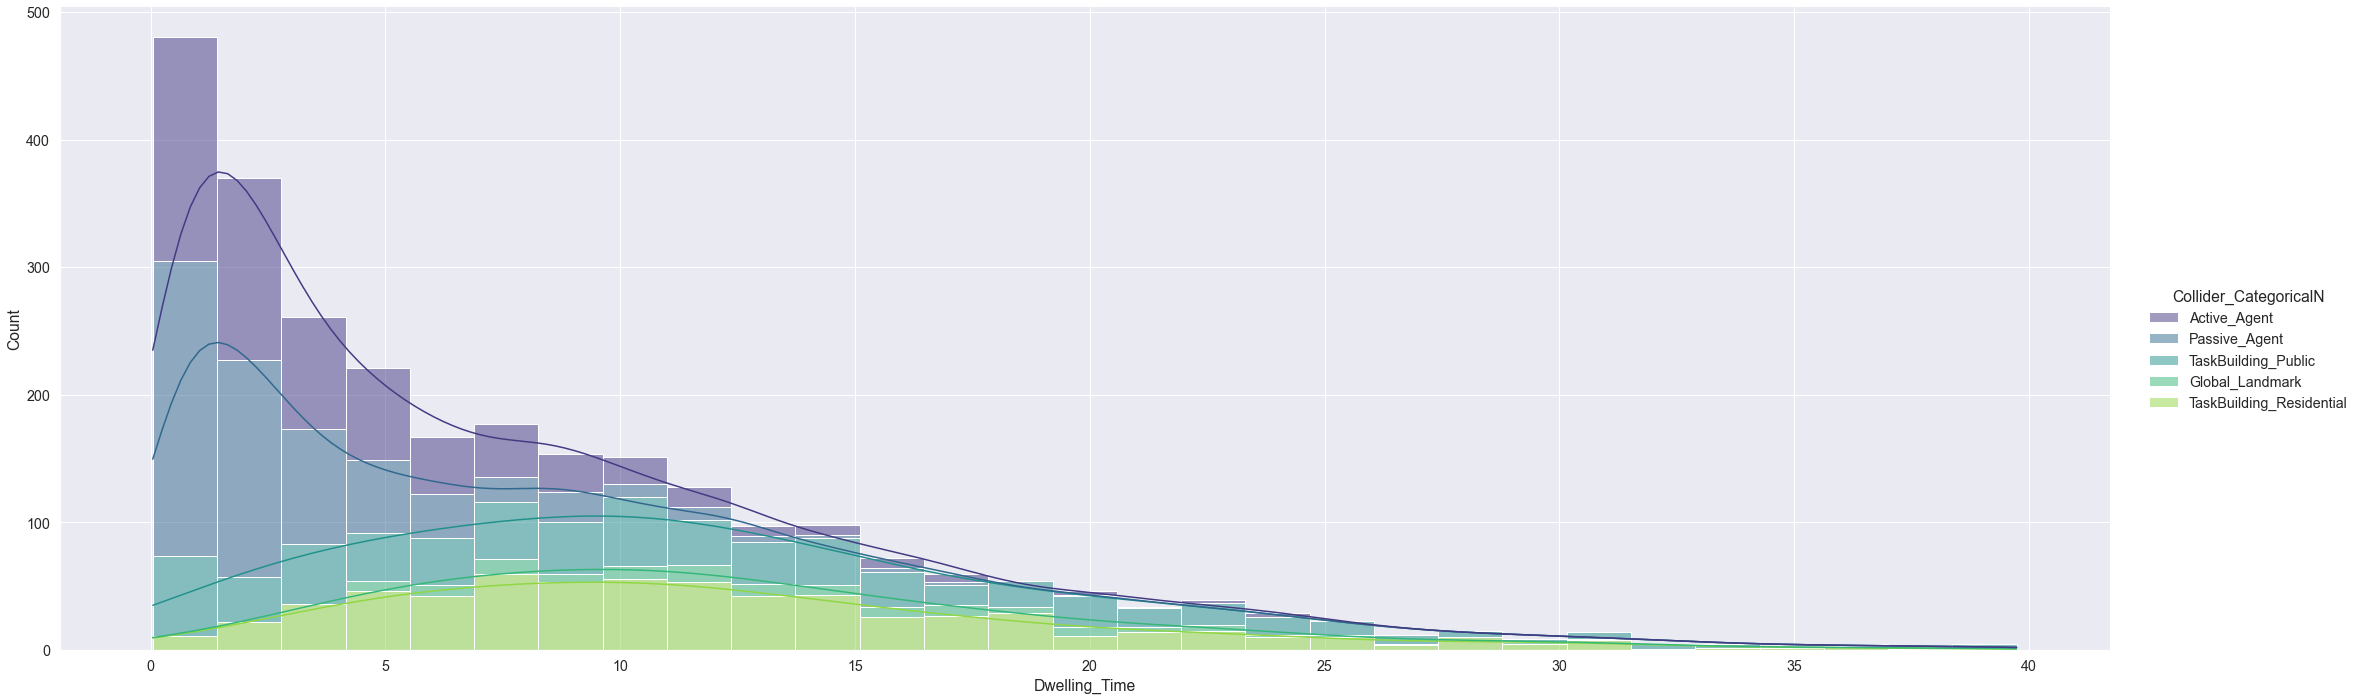

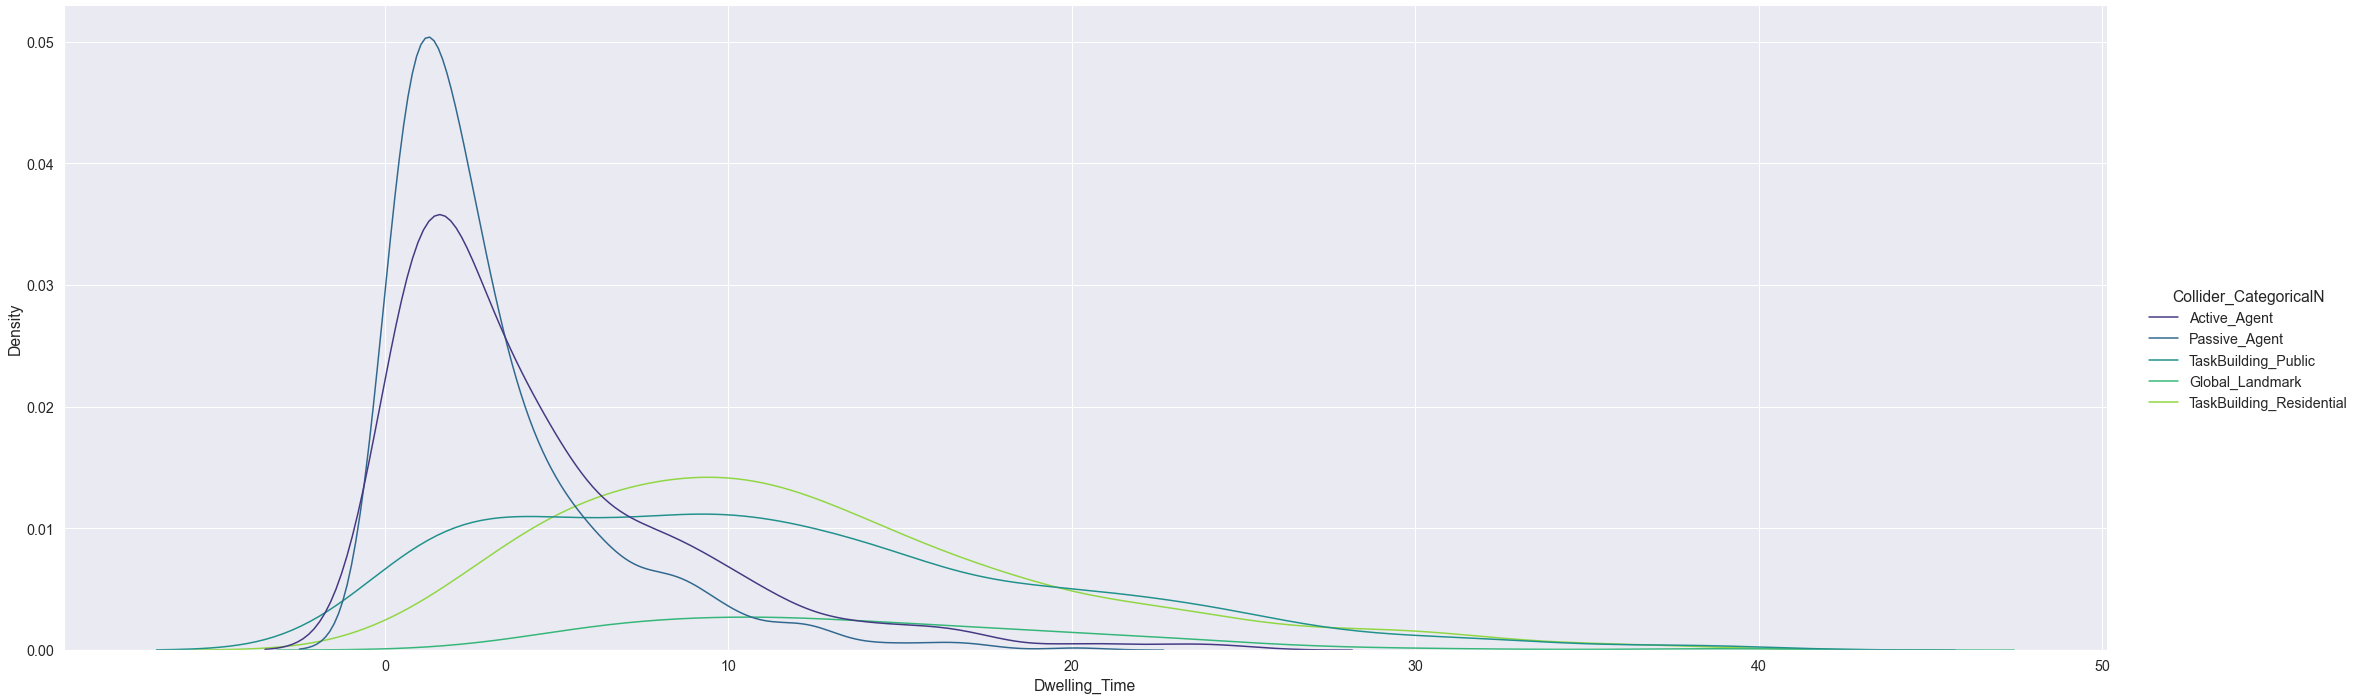

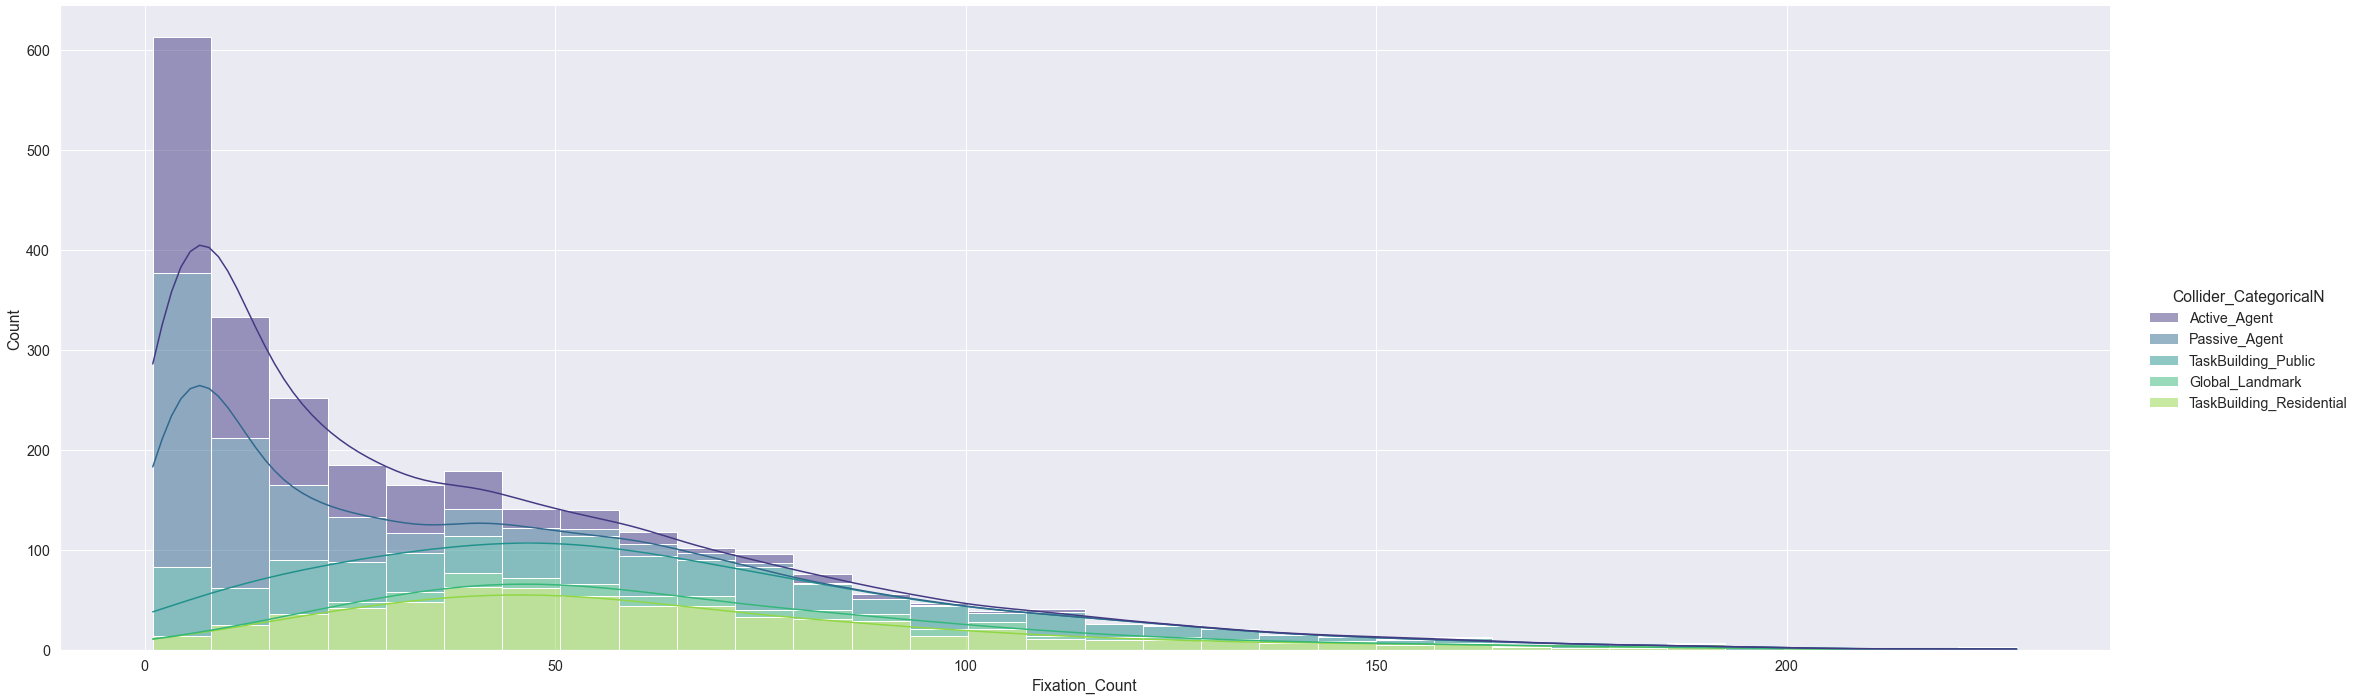

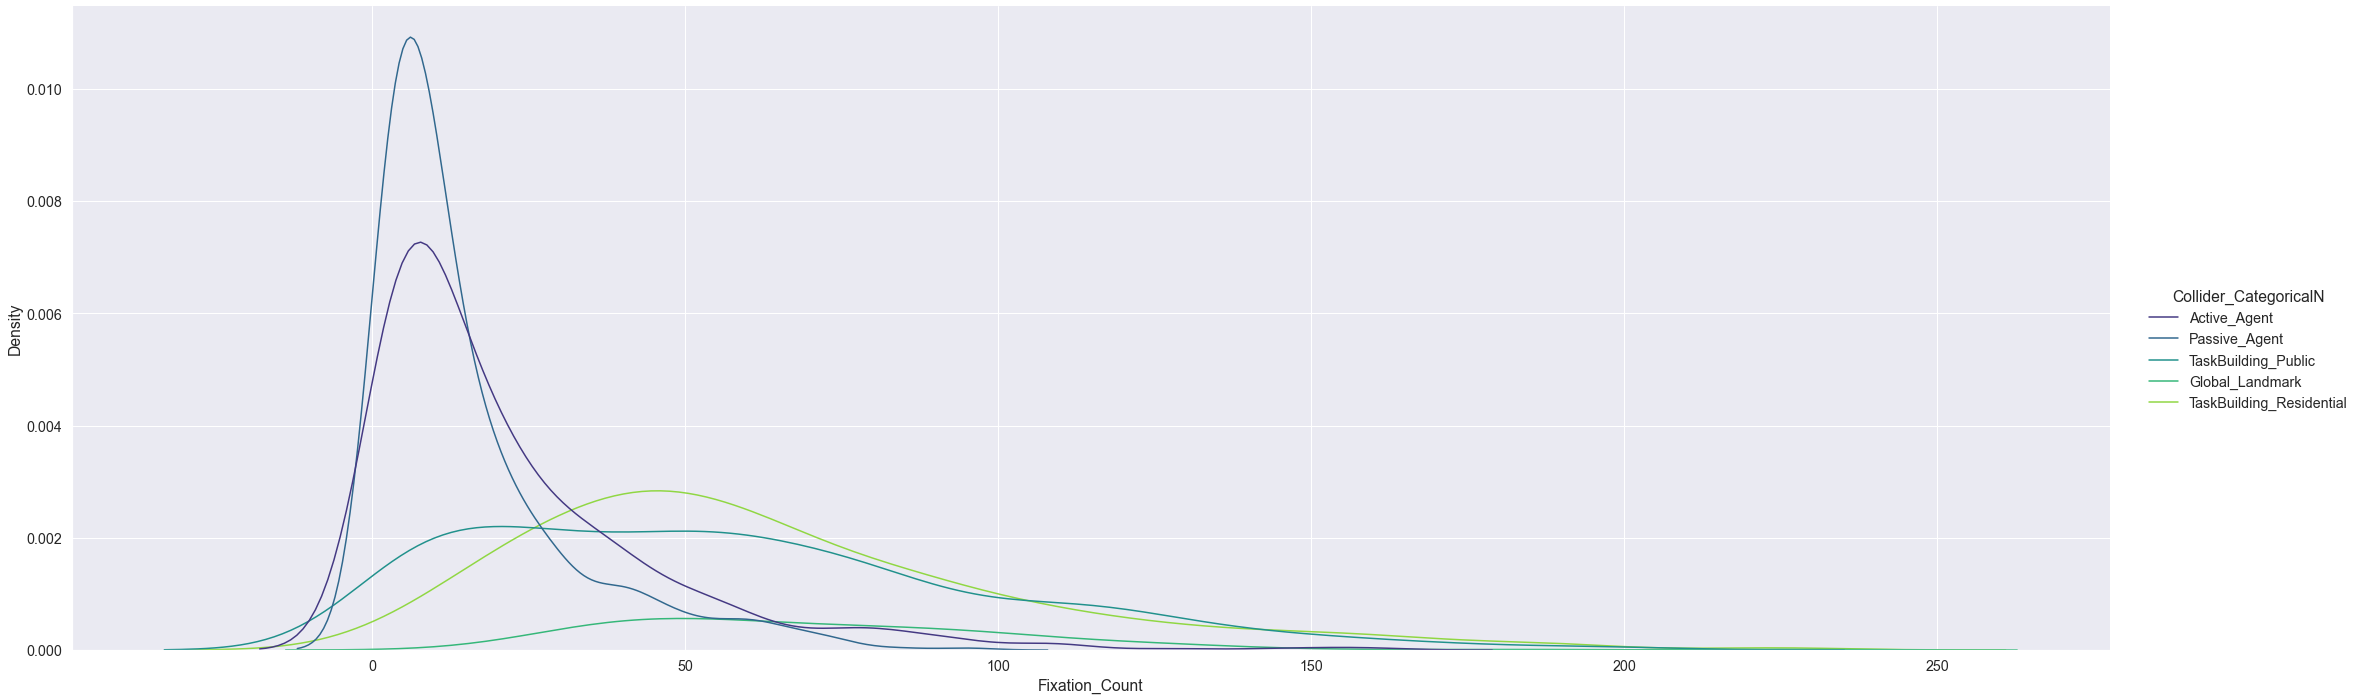

In [81]:
plt.figure(figsize=(25,15))
sns.set(font_scale = 1.3)
sns.displot(x='Dwelling_Time', hue="Collider_CategoricalN",
             data=Fixations[Fixations.Dwelling_Time < 40], 
            height=10, aspect= 3, kde=True, palette="viridis",  multiple="stack")

sns.displot(x='Dwelling_Time', hue="Collider_CategoricalN",
             data=Fixations[Fixations.Dwelling_Time < 40], 
            height=10, aspect= 3, kind="kde", palette="viridis")

sns.displot(x='Fixation_Count', hue="Collider_CategoricalN",
             data=Fixations[Fixations.Dwelling_Time < 40], 
            height=10, aspect= 3, kde=True, palette="viridis",  multiple="stack")

sns.displot(x='Fixation_Count', hue="Collider_CategoricalN",
             data=Fixations[Fixations.Dwelling_Time < 40], 
            height=10, aspect= 3, kind="kde", palette="viridis")

In [84]:
Behavioral = pd.read_csv("/Volumes/TwoTeras/1_Experiment_2/Pointing_Task/Results/BuildingPointingSummary_exp2.csv")

In [85]:
Behavioral.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5595 entries, 0 to 5594
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     5595 non-null   int64  
 1   ID                             5595 non-null   int64  
 2   AbsolutError                   5595 non-null   float64
 3   SignedAngle-+180               5595 non-null   float64
 4   IQR                            5595 non-null   float64
 5   RT                             5595 non-null   float64
 6   DistanceToParticipant          5595 non-null   float64
 7   PointingTaskStartingLocations  5595 non-null   int64  
 8   TrialNumber                    5595 non-null   int64  
 9   StartPointID                   5595 non-null   int64  
 10  ID_for_StartingPosition        5595 non-null   int64  
 11  avatarID                       5595 non-null   int64  
 12  AvatarPresenceCategory         5595 non-null   o

In [86]:
Behavioral.rename({"ID":"SubjectID", "avatarID":"avatar_ID"}, axis=1, inplace=True)
Behavioral

Unnamed: 0  SubjectID  AbsolutError  SignedAngle-+180        IQR  \
0              0       1031     53.795348         53.795348  37.943541   
1              1       1031     49.112601         49.112601  37.943541   
2              2       1031     30.743297         30.743297  37.943541   
3              3       1031    151.423249       -151.423249  37.943541   
4              4       1031     26.825266         26.825266  37.943541   
...          ...        ...           ...               ...        ...   
5590        5590       3540      4.922629         -4.922629  77.822989   
5591        5591       3540     38.229867        -38.229867  77.822989   
5592        5592       3540     94.416805        -94.416805  77.822989   
5593        5593       3540     34.262253        -34.262253  77.822989   
5594        5594       3540    105.225502       -105.225502  77.822989   

             RT  DistanceToParticipant  PointingTaskStartingLocations  \
0     25.217632             307.299805                             21   
1     26.154576             189.228897                             13   
2      5.969860             381.328827                              4   
3     24.303504             258.106903                             21   
4     27.219497              83.646942                             25   
...         ...                    ...                            ...   
5590   4.667887             245.611038                             12   
5591   1.711214             317.307739                              8   
5592   8.394359             227.438751                             24   
5593   9.918083             252.766769                             22   
5594   1.857532             122.948647                             19   

      TrialNumber  StartPointID  ID_for_StartingPosition  avatar_ID  \
0               1             1                        1         33   
1              27             4                        3         33   
2             144            18                        8         33   
3               2             1                        2         43   
4              45             6                        5         43   
...           ...           ...                      ...        ...   
5590          182            23                        6         35   
5591          194            25                        2         35   
5592           47             6                        7          5   
5593           70             9                        6          5   
5594          159            20                        7          5   

     AvatarPresenceCategory  Context BuildingCategory       ImageName  
0                   Omitted     True       meaningful     33_CmANo_20  
1                   Omitted     True       meaningful     33_CmANo_20  
2                   Omitted     True       meaningful     33_CmANo_20  
3                   Present    False   Not meaningful        43_Sa_55  
4                   Omitted    False   Not meaningful      43_SaNo_55  
...                     ...      ...              ...             ...  
5590                Omitted     True       meaningful     35_CmANo_42  
5591                Omitted     True       meaningful     35_CmANo_42  
5592                Omitted     True       meaningful  05_CmANoAct_05  
5593                Present     True       meaningful    05_CmAAct_05  
5594                Present     True       meaningful    05_CmAAct_05  

[5595 rows x 16 columns]

In [160]:
BehavioralData_Fixations_Wide = Behavioral.merge(wide_Fixations, on=["SubjectID", "avatar_ID"], how="left")
BehavioralData_Fixations_Wide.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5595 entries, 0 to 5594
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     5595 non-null   int64  
 1   SubjectID                      5595 non-null   int64  
 2   AbsolutError                   5595 non-null   float64
 3   SignedAngle-+180               5595 non-null   float64
 4   IQR                            5595 non-null   float64
 5   RT                             5595 non-null   float64
 6   DistanceToParticipant          5595 non-null   float64
 7   PointingTaskStartingLocations  5595 non-null   int64  
 8   TrialNumber                    5595 non-null   int64  
 9   StartPointID                   5595 non-null   int64  
 10  ID_for_StartingPosition        5595 non-null   int64  
 11  avatar_ID                      5595 non-null   int64  
 12  AvatarPresenceCategory         5595 non-null   o

In [208]:
BehavioralData_Fixations_Wide.head()

Unnamed: 0  SubjectID  AbsolutError  SignedAngle-+180        IQR  \
0           0       1031     53.795348         53.795348  37.943541   
1           1       1031     49.112601         49.112601  37.943541   
2           2       1031     30.743297         30.743297  37.943541   
3           8       1031     12.854896        -12.854896  37.943541   
4           9       1031     30.975964         30.975964  37.943541   

          RT  DistanceToParticipant  PointingTaskStartingLocations  \
0  25.217632             307.299805                             21   
1  26.154576             189.228897                             13   
2   5.969860             381.328827                              4   
3  13.345377             380.950958                             21   
4  24.095184             314.237366                             11   

   TrialNumber  StartPointID  ID_for_StartingPosition  avatar_ID  \
0            1             1                        1         33   
1           27             4                        3         33   
2          144            18                        8         33   
3            3             1                        3         44   
4           33             5                        1         44   

  AvatarPresenceCategory  Context BuildingCategory    ImageName  \
0                Omitted     True       meaningful  33_CmANo_20   
1                Omitted     True       meaningful  33_CmANo_20   
2                Omitted     True       meaningful  33_CmANo_20   
3                Present    False   Not meaningful     44_Sa_18   
4                Present    False   Not meaningful     44_Sa_18   

   Dwealling_Time_Building_Gaze  Fixation_Count_Building_Gaze  \
0                      4.139454                          28.0   
1                      4.139454                          28.0   
2                      4.139454                          28.0   
3                      9.873057                          55.0   
4                      9.873057                          55.0   

   Dwealling_Time_Agent_Gaze  Fixation_Count_Agent_Gaze  
0                   8.445507                       43.0  
1                   8.445507                       43.0  
2                   8.445507                       43.0  
3                   2.857504                       10.0  
4                   2.857504                       10.0

In [91]:
BehavioralData_Fixations.head(50)

Unnamed: 0  SubjectID  AbsolutError  SignedAngle-+180        IQR  \
0            0       1031     53.795348         53.795348  37.943541   
1            0       1031     53.795348         53.795348  37.943541   
2            1       1031     49.112601         49.112601  37.943541   
3            1       1031     49.112601         49.112601  37.943541   
4            2       1031     30.743297         30.743297  37.943541   
5            2       1031     30.743297         30.743297  37.943541   
6            3       1031    151.423249       -151.423249  37.943541   
7            4       1031     26.825266         26.825266  37.943541   
8            5       1031     17.372352         17.372352  37.943541   
9            6       1031    150.396011       -150.396011  37.943541   
10           7       1031     31.218964         31.218964  37.943541   
11           8       1031     12.854896        -12.854896  37.943541   
12           8       1031     12.854896        -12.854896  37.943541   
13           9       1031     30.975964         30.975964  37.943541   
14           9       1031     30.975964         30.975964  37.943541   
15          10       1031     20.376197         20.376197  37.943541   
16          10       1031     20.376197         20.376197  37.943541   
17          11       1031     55.034820        -55.034820  37.943541   
18          11       1031     55.034820        -55.034820  37.943541   
19          12       1031    131.262548       -131.262548  37.943541   
20          12       1031    131.262548       -131.262548  37.943541   
21          13       1031     41.868383         41.868383  37.943541   
22          13       1031     41.868383         41.868383  37.943541   
23          14       1031      2.834251         -2.834251  37.943541   
24          14       1031      2.834251         -2.834251  37.943541   
25          15       1031      5.744315         -5.744315  37.943541   
26          15       1031      5.744315         -5.744315  37.943541   
27          16       1031      0.101959         -0.101959  37.943541   
28          16       1031      0.101959         -0.101959  37.943541   
29          17       1031      0.255923          0.255923  37.943541   
30          17       1031      0.255923          0.255923  37.943541   
31          18       1031      1.442089          1.442089  37.943541   
32          18       1031      1.442089          1.442089  37.943541   
33          19       1031     16.121959         16.121959  37.943541   
34          19       1031     16.121959         16.121959  37.943541   
35          20       1031     31.191239         31.191239  37.943541   
36          20       1031     31.191239         31.191239  37.943541   
37          21       1031      5.049666          5.049666  37.943541   
38          21       1031      5.049666          5.049666  37.943541   
39          22       1031      4.670335          4.670335  37.943541   
40          22       1031      4.670335          4.670335  37.943541   
41          23       1031      4.193784          4.193784  37.943541   
42          23       1031      4.193784          4.193784  37.943541   
43          24       1031    108.347642       -108.347642  37.943541   
44          24       1031    108.347642       -108.347642  37.943541   
45          25       1031     37.219914         37.219914  37.943541   
46          25       1031     37.219914         37.219914  37.943541   
47          26       1031     64.325469         64.325469  37.943541   
48          26       1031     64.325469         64.325469  37.943541   
49          27       1031      7.776687          7.776687  37.943541   

           RT  DistanceToParticipant  PointingTaskStartingLocations  \
0   25.217632             307.299805                             21   
1   25.217632             307.299805                             21   
2   26.154576             189.228897                             13   
3   26.154576             189.228897           

In [92]:
BehavioralData_Fixations[BehavioralData_Fixations.avatar_ID == 29]

Unnamed: 0  SubjectID  AbsolutError  SignedAngle-+180        IQR  \
367           189       1031      0.919933          0.919933  37.943541   
368           189       1031      0.919933          0.919933  37.943541   
369           190       1031      3.726070          3.726070  37.943541   
370           190       1031      3.726070          3.726070  37.943541   
775           398       1268     67.015864        -67.015864  82.815181   
...           ...        ...           ...               ...        ...   
10469        5305       2069      0.831215         -0.831215  68.997178   
10470        5306       2069     24.009141        -24.009141  68.997178   
10471        5306       2069     24.009141        -24.009141  68.997178   
10917        5543       3540     89.254544         89.254544  77.822989   
10918        5543       3540     89.254544         89.254544  77.822989   

              RT  DistanceToParticipant  PointingTaskStartingLocations  \
367    25.446791             171.838623                             23   
368    25.446791             171.838623                             23   
369     4.360337             364.276306                             27   
370     4.360337             364.276306                             27   
775     8.514832             364.276306                             27   
...          ...                    ...                            ...   
10469   5.063022              21.887957                             24   
10470  13.154035             240.303284                              3   
10471  13.154035             240.303284                              3   
10917   3.819721             364.276306                             27   
10918   3.819721             364.276306                             27   

       TrialNumber  StartPointID  ...  avatar_ID  AvatarPresenceCategory  \
367             81            11  ...         29                 Omitted   
368             81            11  ...         29                 Omitted   
369             99            13  ...         29                 Omitted   
370             99            13  ...         29                 Omitted   
775             29             4  ...         29                 Omitted   
...            ...           ...  ...        ...                     ...   
10469          202            26  ...         29                 Present   
10470          211            27  ...         29                 Omitted   
10471          211            27  ...         29                 Omitted   
10917          117            15  ...         29                 Present   
10918          117            15  ...         29                 Present   

      Context  BuildingCategory    ImageName         recoded  \
367      True        meaningful  29_CmANo_50           29_Sa   
368      True        meaningful  29_CmANo_50  TaskBuilding_4   
369      True        meaningful  29_CmANo_50           29_Sa   
370      True        meaningful  29_CmANo_50  TaskBuilding_4   
775      True        meaningful  29_CmANo_50           29_Sa   
...       ...               ...          ...             ...   
10469    True        meaningful    29_CmA_50  TaskBuilding_4   
10470    True        meaningful  29_CmANo_50           29_Sa   
10471    True        meaningful  29_CmANo_50  TaskBuilding_4   
10917    True        meaningful    29_CmA_50           29_Sa   
10918    True        meaningful    29_CmA_50  TaskBuilding_4   

          Collider_CategoricalN Dwelling_Time  Fixation_Count       Category  
367               Passive_Agent      5.306373              29     Agent_Gaze  
368    TaskBuilding_Residential      8.213238              37  Building_Gaze  
369               Passive_Agent      5.306373              29     Agent_Gaze  
370    TaskBuilding_Residential      8.213238              37  Building_Gaze  
775               Passive_Agent      2.059342               9     Agent_Gaze  
...                         ...           ...             ...

In [93]:
BehavioralData_Fixations["Agent_Action_level"] = np.where(BehavioralData_Fixations.avatar_ID > 28, "Passive", "Active")
BehavioralData_Fixations_Wide["Agent_Action_level"] = np.where(BehavioralData_Fixations_Wide.avatar_ID > 28, "Passive", "Active")

In [161]:
BehavioralData_Fixations_Wide.to_csv("/Volumes/TwoTeras/1_Experiment_2/Eye_Tracking/Pre_processed/Data_Sets/BehavioralData_Fixations_Wide.csv")

In [95]:
BehavioralData_Fixations_Wide[['Dwelling_Time_Agent_Gaze', 'Dwelling_Time_Building_Gaze',
       'Fixation_Count_Agent_Gaze', 'Fixation_Count_Building_Gaze',  'AbsolutError' ]].corr().style.background_gradient(cmap="viridis")

<AxesSubplot: xlabel='AbsolutError', ylabel='Dwelling_Time'>

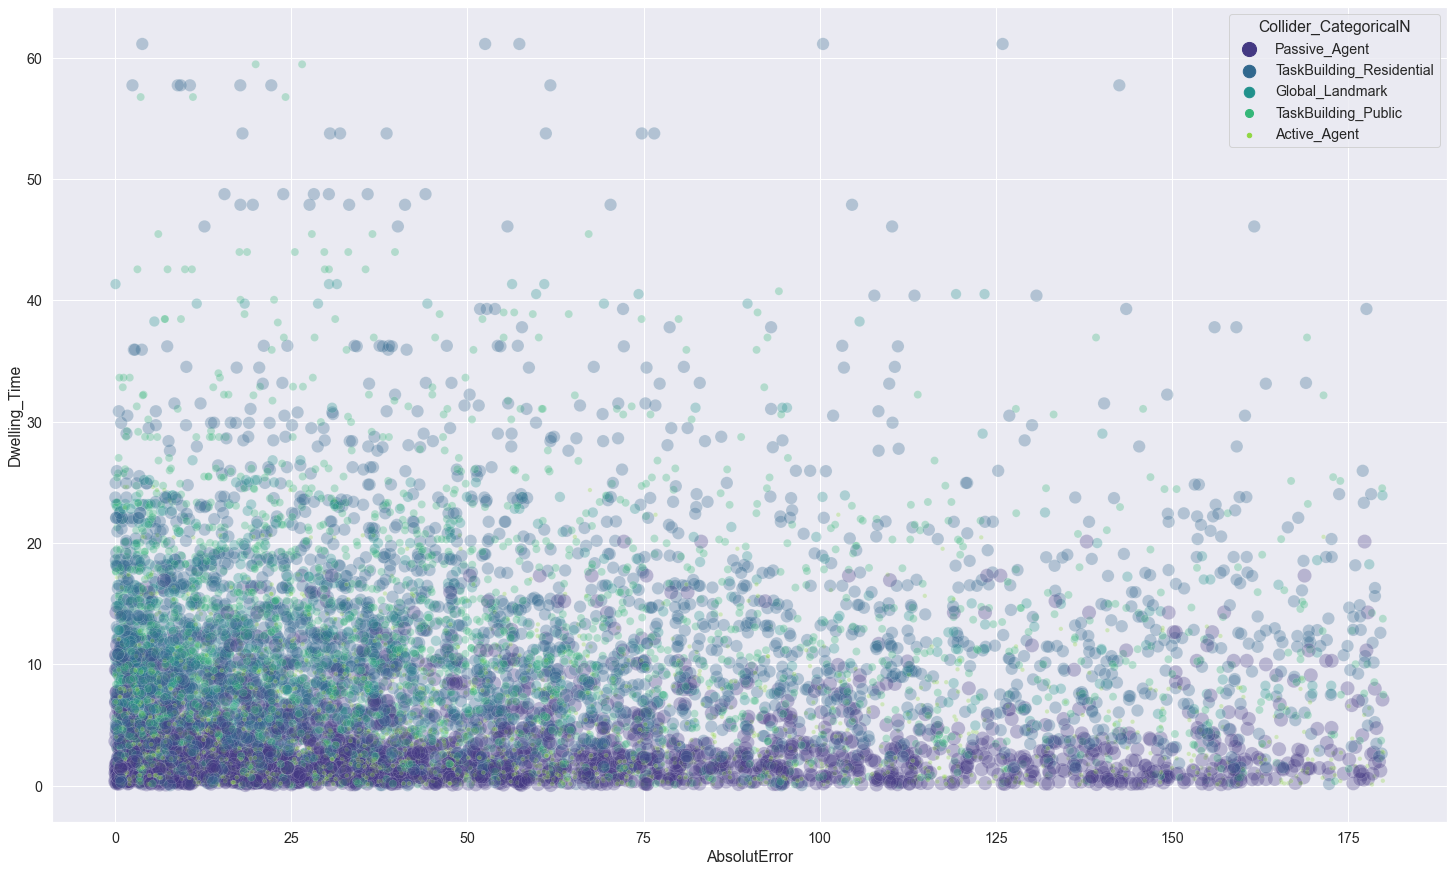

In [123]:
plt.figure(figsize=(25,15))
sns.scatterplot(x='AbsolutError', y='Dwelling_Time', hue="Collider_CategoricalN",
                size="Collider_CategoricalN", sizes=(20,200), legend="full", data=BehavioralData_Fixations, alpha=0.3, palette="viridis")

In [98]:
data_frame_gaze_no_out_ONLY_TEST.groupby([ "Hit_Object_Category", "Session"])["length"].agg(['median','count','mean','std','max', 'min'])

median  count      mean       std       max  \
Hit_Object_Category Session                                                  
Agent               1        0.173093   6080  0.206810  0.138044  0.593216   
                    2        0.172610   4850  0.205439  0.138348  0.594706   
                    3        0.166657   5317  0.202819  0.137189  0.593216   
                    4        0.166656   4326  0.205247  0.139894  0.593153   
                    5        0.166656   4126  0.202881  0.137646  0.593716   
Building            1        0.155250  12978  0.185603  0.122758  0.594698   
                    2        0.165865  12414  0.194375  0.128303  0.594710   
                    3        0.154753  12315  0.185178  0.125202  0.594704   
                    4        0.155748  12352  0.189753  0.126810  0.594096   
                    5        0.161697  11805  0.189522  0.125231  0.594212   
Global_Landmark     1        0.161193   2156  0.192403  0.127459  0.593199   
                    2        0.169632   1971  0.200408  0.132259  0.594208   
                    3        0.166656   1653  0.194053  0.126314  0.592582   
                    4        0.177303   1618  0.201845  0.130027  0.588753   
                    5        0.174344   1644  0.202589  0.129285  0.592228   
Graffity            1        0.181527   4428  0.212358  0.134461  0.593708   
                    2        0.184017   3962  0.211846  0.135351  0.594157   
                    3        0.185503   3840  0.214164  0.136424  0.594708   
                    4        0.187984   3164  0.211612  0.132943  0.594710   
                    5        0.188482   3683  0.215588  0.135449  0.594211   

                                  min  
Hit_Object_Category Session            
Agent               1        0.013885  
                    2        0.021328  
                    3        0.022320  
                    4        0.022321  
                    5        0.011408  
Building            1        0.010913  
                    2        0.011409  
                    3        0.010913  
                    4        0.010912  
                    5        0.011904  
Global_Landmark     1        0.010911  
                    2        0.010912  
                    3        0.010912  
                    4        0.010912  
                    5        0.011409  
Graffity            1        0.032736  
                    2        0.021823  
                    3        0.032240  
                    4        0.032736  
                    5        0.031743

In [ ]:
summary_name_stats_fix_length_NS_Agent.to_csv("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/summary_name_stats_fix_length_NS_Agent.csv")

In [102]:
summary_name_stats_fix_length_NS = pd.DataFrame(data_frame_gaze_no_out_ONLY_TEST.groupby([ "SubjectID",  "Hit_Object_Category", "Collider_CategoricalN","Session" ])["length"].agg(['count','mean','median','std','max', 'min']))

In [103]:
data_frame_gaze_no_out_ONLY_TEST.columns

Index(['index', 'SubjectID', 'Session', 'SessionSubsection',
       'timeStampDataPointEnd', 'combinedGazeValidityBitmask',
       'eyePositionCombinedWorld.x', 'eyePositionCombinedWorld.y',
       'eyePositionCombinedWorld.z', 'eyeDirectionCombinedWorld.y',
       'eyeDirectionCombinedWorld.z', 'eyeDirectionCombinedLocal.x',
       'eyeDirectionCombinedLocal.y', 'eyeDirectionCombinedLocal.z',
       'playerBodyPosition.x', 'playerBodyPosition.y', 'playerBodyPosition.z',
       'hitColliderType', 'hitObjectColliderName', 'ordinalOfHit',
       'hitPointOnObject_x', 'hitPointOnObject_y', 'hitPointOnObject_z',
       'Eucledian_distance', 'Collider_Categorical', 'Face_Hits', 'Time_Shift',
       'Continuous_Time', 'Bitmask_flag', 'Interpolated_collider',
       ' eyePositionCombinedWorld.x', 'Collider_shift', 'counter',
       'Time_of_Gaze', 'Gaze', 'combined_vel', 'thresh', 'isFix',
       'corrected_vel', 'events', 'length', 'distance', 'avg_dist', 'names',
       'Collider_Categorica

In [104]:
summary_name_stats_fix_length_NS.reset_index(inplace=True)

In [105]:
summary_name_stats_fix_length_NS

SubjectID Hit_Object_Category     Collider_CategoricalN  Session  count  \
0         1031               Agent              Active_Agent        1    100   
1         1031               Agent              Active_Agent        2     67   
2         1031               Agent              Active_Agent        3    427   
3         1031               Agent              Active_Agent        4    409   
4         1031               Agent              Active_Agent        5    241   
..         ...                 ...                       ...      ...    ...   
870       9627            Graffity  TaskBuilding_Residential        1    123   
871       9627            Graffity  TaskBuilding_Residential        2     84   
872       9627            Graffity  TaskBuilding_Residential        3    103   
873       9627            Graffity  TaskBuilding_Residential        4     87   
874       9627            Graffity  TaskBuilding_Residential        5     95   

         mean    median       std       max       min  
0    0.174979  0.133424  0.134390  0.576352  0.032736  
1    0.213217  0.188481  0.137245  0.588753  0.044144  
2    0.175843  0.133441  0.131388  0.588257  0.033231  
3    0.178371  0.138387  0.127835  0.575867  0.033233  
4    0.174994  0.132433  0.133166  0.588774  0.033231  
..        ...       ...       ...       ...       ...  
870  0.231890  0.186992  0.152058  0.588752  0.032736  
871  0.244717  0.222952  0.155103  0.588752  0.033231  
872  0.236429  0.211297  0.141194  0.577347  0.033232  
873  0.285725  0.288673  0.140301  0.553536  0.044145  
874  0.235420  0.221714  0.142803  0.574375  0.031743  

[875 rows x 10 columns]

In [106]:
summary_name_stats_fix_length_NS_Agent = summary_name_stats_fix_length_NS[summary_name_stats_fix_length_NS.Hit_Object_Category == 'Agent'].copy()
summary_name_stats_fix_length_NS_Agent['Agent_Category'] = summary_name_stats_fix_length_NS_Agent['Collider_CategoricalN'].str.contains('Active')
summary_name_stats_fix_length_NS_Agent.loc[:, 'Agent_Category'] = summary_name_stats_fix_length_NS_Agent['Agent_Category'].replace({True: 'Active', False: 'Passive'})

In [107]:
summary_name_stats_fix_length_NS_Agent

SubjectID Hit_Object_Category Collider_CategoricalN  Session  count  \
0         1031               Agent          Active_Agent        1    100   
1         1031               Agent          Active_Agent        2     67   
2         1031               Agent          Active_Agent        3    427   
3         1031               Agent          Active_Agent        4    409   
4         1031               Agent          Active_Agent        5    241   
..         ...                 ...                   ...      ...    ...   
845       9627               Agent         Passive_Agent        1     25   
846       9627               Agent         Passive_Agent        2     33   
847       9627               Agent         Passive_Agent        3     14   
848       9627               Agent         Passive_Agent        4     16   
849       9627               Agent         Passive_Agent        5     22   

         mean    median       std       max       min Agent_Category  
0    0.174979  0.133424  0.134390  0.576352  0.032736         Active  
1    0.213217  0.188481  0.137245  0.588753  0.044144         Active  
2    0.175843  0.133441  0.131388  0.588257  0.033231         Active  
3    0.178371  0.138387  0.127835  0.575867  0.033233         Active  
4    0.174994  0.132433  0.133166  0.588774  0.033231         Active  
..        ...       ...       ...       ...       ...            ...  
845  0.236771  0.229648  0.131600  0.466240  0.044144        Passive  
846  0.223636  0.196417  0.142430  0.555024  0.033728        Passive  
847  0.226282  0.207081  0.134741  0.508894  0.061503        Passive  
848  0.169508  0.143096  0.099876  0.430527  0.033729        Passive  
849  0.214320  0.204602  0.094499  0.388373  0.033232        Passive  

[250 rows x 11 columns]

In [ ]:
summary_name_stats_fix_length.shape

In [ ]:
summary_stats_fix_length = pd.DataFrame(data_frame_gaze_no_out.groupby(["Collider_CategoricalN", "SubjectID", "Session"])["length"].agg(['count','mean','median','std','max', 'min']))
summary_stats_fix_length.reset_index(inplace=True)

In [ ]:
summary_name_stats_fix_length_BIG= pd.DataFrame(data_frame_gaze_no_out_ONLY_TEST.groupby([ "SubjectID", "Hit_Object_Category", "Collider_CategoricalN","Session" ])["length"].agg(['count','mean','median','std','max', 'min']))

In [ ]:
summary_name_stats_fix_length_BIG.reset_index(inplace=True)
summary_name_stats_fix_length_BIG.head(20)

In [ ]:
summary_name_stats_fix_length_BIG.to_csv("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/Grouped_Gazes.cvs")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Hit_Object_Category", y="median", hue="Session", data=summary_name_stats_fix_length_BIG[(summary_name_stats_fix_length_BIG.Hit_Object_Category == "Agent")], \
            height=5, aspect=3, kind='box').set(title="Median length of gazes per session")
ax = sns.stripplot(x="Hit_Object_Category", y="median", hue="Session", data=summary_name_stats_fix_length_BIG[summary_name_stats_fix_length_BIG.Hit_Object_Category == "Agent"], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/counts.png',  bbox_inches='tight')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.catplot(x="Hit_Object_Category", y="count", hue="Session", data=summary_name_stats_fix_length_BIG[(summary_name_stats_fix_length_BIG.Hit_Object_Category == "Agent")], \
            height=5, aspect=3, kind='box').set(title="Number of gazes per session")
ax = sns.stripplot(x="Hit_Object_Category", y="count", hue="Session", data=summary_name_stats_fix_length_BIG[summary_name_stats_fix_length_BIG.Hit_Object_Category == "Agent"], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/counts.png',  bbox_inches='tight')

In [ ]:
dy='Hit_Object_Category'; dx='count'; ort='h'; pal = sns.color_palette(); sigma = .2
f, ax = plt.subplots(figsize=(18, 15))

import ptitprince as pt

ax=pt.half_violinplot(x = dx, y = dy, data = summary_name_stats_fix_length_BIG, palette = pal, bw = .2, cut = 0.,
                      scale = 'area', width = .6, inner = None, orient = ort)
ax=sns.stripplot(x = dx, y = dy, data = summary_name_stats_fix_length_BIG, palette = pal, edgecolor = 'white',
                 size = 3, jitter = 1, zorder = 0, orient = ort)
ax=sns.boxplot(x = dx, y = dy, data = summary_name_stats_fix_length_BIG, color = 'black', width = .15, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', 'zorder':10},\
            showfliers=True, whiskerprops = {'linewidth':2, 'zorder':10},\
            saturation = 1, orient = ort) 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="count", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")], \
            height=5, aspect=3, kind='box').set(title="Number of gazes per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="count",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/count.png')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="count", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent_Face")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent_Face")], \
            height=5, aspect=3, kind='box').set(title="Number of gazes per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="count",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent_Face")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent_Face")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
#plt.ylim(top=100)
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/count_Faces.png',  bbox_inches='tight')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="median", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent_Face")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent_Face")], \
            height=6, aspect=3, kind='box').set(title="Median gaze duration per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="median",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent_Face")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent_Face")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/Median_Duration_Faces.png',  bbox_inches='tight')

In [ ]:
data_frame_gaze_no_out_ONLY_TEST.tail()

In [ ]:
data_frame_gaze_no_out_ONLY_TEST.columns

In [ ]:
data_frame_gaze_no_out_ONLY_TEST.groupby(["SubjectID", "SessionSubsection"])['']

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="median", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")&(summary_stats_fix_length.Collider_CategoricalN != "Building")], \
            height=6, aspect=3, kind='box').set(title="Median gaze duration per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="median",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")&(summary_stats_fix_length.Collider_CategoricalN != "Building")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/Median_Duration_All.png',  bbox_inches='tight')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="max", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent_Face")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent_Face")], \
            height=5, aspect=4, kind='box').set(title="Maximal duration of gaze duration per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="max",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent_Face")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent_Face")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/MedianDurationFaces.png')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="std", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")&(summary_stats_fix_length.Collider_CategoricalN != "Building")], \
            height=5, aspect=4, kind='box').set(title="Standard Deviation of gaze duration per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="std",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")&(summary_stats_fix_length.Collider_CategoricalN != "Building")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
ax.set_ylabel("Standard Deviation of gaze duration")
plt.savefig('/Users/tracysanchezpacheco/Desktop/MedianDurationFaces.png', bbox_inches='tight')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="min", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")&(summary_stats_fix_length.Collider_CategoricalN != "Building")], \
            height=7, aspect=4, kind='box').set(title="Minimum duration duration of gazes per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="min",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")&(summary_stats_fix_length.Collider_CategoricalN != "Building")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
#plt.ylim(top=1)
ax.get_legend().remove()
ax.set_ylabel("Minimum duration of gazes per session")
plt.savefig('/Users/tracysanchezpacheco/Desktop/count.png', bbox_inches='tight')

In [ ]:
HumanA = pd.read_csv("/Users/tracysanchezpacheco/Documents/Resources/humanA_Behavioural.csv")

In [ ]:
HumanA["AE_Median_Standard_Duration"] = np.nanmedian(abs(HumanA.AbsolutError - np.nanmedian(HumanA.AbsolutError))) * 1.4826
HumanA["AE_mad_z"] = abs(HumanA.AbsolutError.tolist() - np.nanmedian(HumanA.AbsolutError)) / HumanA.AE_Median_Standard_Duration.tolist()
HumanA["Outlier_AE_Length"] = np.where(HumanA["AE_mad_z"] > 3.5, "Out", "Stays")
HumanA["RT_Median_Standard_Duration"] = np.nanmedian(abs(HumanA.RT - np.nanmedian(HumanA.RT))) * 1.4826
HumanA["RT_mad_z"] = abs(HumanA.RT.tolist() - np.nanmedian(HumanA.RT)) / HumanA.RT_Median_Standard_Duration.tolist()
HumanA["Outlier_RT_Length"] = np.where(HumanA["RT_mad_z"] > 3.5, "Out", "Stays")
HumanA_OUT = HumanA[(HumanA.Outlier_AE_Length != "Out") & (HumanA.Outlier_RT_Length != "Out")]
HumanA_OUT.to_csv("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/HumanA_NoOut.cvs")

In [ ]:
data_frame.head(50)

In [ ]:
data_frame.info()

In [ ]:
data_frame.to_csv("/Volumes/SSD/00_Data_Processing/Pre_processed/Complete_Data_AngularV.cvs")

In [ ]:
One_participant.columns

In [ ]:
One_participant.drop(columns=['Unnamed: 0', 'level_0','Unnamed: 0.1', 'Unnamed: 0.1.1'], inplace=True)

In [ ]:
One_participant.events.value_counts()

In [ ]:
One_participant['avg_shift'] = One_participant['avg_dist'].shift(1) != One_participant['avg_dist']

In [ ]:
data_frame.iloc[115318:115322,6:9]

In [ ]:
data_frame.info()

In [ ]:
One_participant.iloc[115521:115532,45:50]

In [ ]:
One_participant.iloc[115318:115322,6]

In [ ]:
One_participant.iloc[115322,6] - One_participant.iloc[115318,6]

In [ ]:
One_participant.iloc[115532,6] - One_participant.iloc[115521,6]

In [ ]:
One_participant.tail(200)

In [ ]:
pd.set_option('display.max_rows', 500)

In [ ]:
df